# 📘 信用卡流失預測模型 - v1_baseline (XGBoost)

## 🔧 Notebook 簡介
本 Notebook 是我們的 baseline (只做get_dummies)模型，用來預測信用卡客戶是否會流失（`Attrition_Flag = 1`）。

---

## 🛠️ 前處理流程

- 🔢 使用 `pd.get_dummies()` 對以下類別欄位做 one-hot encoding：
  - `'Gender'`, `'Education_Level'`, `'Marital_Status'`, `'Income_Category'`, `'Card_Category'`
- ❌ 未進行缺失值填補或 Unknown 處理
- 🏷️ 將 `Attrition_Flag` 轉為 0（Existing Customer）與 1（Attrited Customer）

---

## 🤖 模型設定（XGBClassifier）

- `objective='binary:logistic'`：二元分類任務
- `eval_metric='logloss'`
- `max_depth=4`：防止過擬合
- `learning_rate=0.1`
- `n_estimators=100`
- `scale_pos_weight = 負類數量 / 正類數量`：處理類別不平衡
- 使用 `.fit(X_train, y_train)` 進行訓練

---

## 📈 模型表現（測試集）

| 指標               | 結果     |
|--------------------|----------|
| Accuracy           | 0.96     |
| Recall（流失客戶）| 0.96     |
| Precision（流失）  | 0.82     |
| F1-score（流失）   | 0.88     |
| ROC AUC            | 0.9918    |

Confusion Matrix:
[[1632   69]
 [  13  312]]

---

## 📊 特徵重要性分析

- 🔹 預設 importance（split 次數） Top 3 : `Total_Trans_Amt`, `Total_Trans_Ct`, `Total_Amt_Chng_Q4_Q1`
- 🔸 Gain-based importance（資訊貢獻） Top 3：`Total_Trans_Ct`, `Total_Revolving_Bal`, `Total_Relationship_Count`
- 🆕 Education_Level_Unknown 進入 Gain 排名前 10，代表其資訊價值不低
-  ❗ 某些變數如 CLIENTNUM 雖然排名高，但無實質意義，後續可排除

---

## 🧠 SHAP 模型解釋（單一樣本）

- `Total_Trans_Ct` 為主要降低流失機率的變數（顯著負貢獻）
- `Total_Trans_Amt`、`Total_Revolving_Bal` 為降低風險的重要參數
- `Months_Inactive_12_mon` 仍為顯著提高流失風險的正向變數

---

## 🔚 小結與後續建議

- ✅ 本版本為乾淨的 baseline 模型，模型整體效能穩定，AUC 高達 **0.9918**，recall 達 **96%**，可作為日後改良的比較基準

- 🔁 後續版本可探索：
  - 將 `Unknown` 類別轉為二元 flag 與其他型態比較
  - 使用 `OrdinalEncoding` 處理具順序欄位（如 `Income_Category`）
  - 導入欠採樣、SMOTE 或 `GridSearchCV` 做調參優化


## 一、匯入資料
查看資料

In [1]:
import pandas as pd

# 讀取訓練與測試資料
train_df = pd.read_csv("../data/bank_train.csv")
test_df = pd.read_csv("../data/bank_test.csv")

# 檢查資料大小
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# 顯示前 5 筆資料
display(train_df.head())
display(test_df.head())


Train shape: (8101, 21)
Test shape: (2026, 21)


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,806407308,54,F,3,College,Single,Unknown,Blue,49,6,...,3,13184.0,0,13184.0,1.166,2047,33,0.179,0.000,Attrited Customer
1,801786483,51,M,0,High School,Single,$80K - $120K,Blue,45,3,...,3,10648.0,2517,8131.0,0.708,4930,89,0.978,0.236,Existing Customer
2,779870883,45,F,4,High School,Single,$40K - $60K,Blue,29,3,...,1,4595.0,1781,2814.0,0.708,3746,68,0.545,0.388,Existing Customer
3,720336708,53,M,3,Doctorate,Married,$40K - $60K,Blue,35,5,...,2,3789.0,1706,2083.0,1.047,1609,42,0.680,0.450,Existing Customer
4,716769783,48,F,2,Graduate,Married,Unknown,Blue,40,3,...,4,5104.0,736,4368.0,0.679,3943,78,0.696,0.144,Existing Customer


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,720943308,47,M,3,Graduate,Single,$60K - $80K,Silver,36,1,...,2,30498.0,1990,28508.0,0.839,16202,120,0.791,0.065,Existing Customer
1,710879283,51,M,1,High School,Married,Less than $40K,Blue,41,3,...,3,1438.3,0,1438.3,0.623,4312,81,0.723,0.000,Existing Customer
2,787800108,55,M,2,College,Married,$80K - $120K,Blue,45,5,...,2,2929.0,2431,498.0,1.632,1903,39,0.625,0.830,Existing Customer
3,789200208,40,F,4,Uneducated,Married,Unknown,Blue,29,2,...,3,3326.0,2181,1145.0,0.827,13583,110,0.746,0.656,Existing Customer
4,711332883,62,M,1,High School,Single,$60K - $80K,Blue,46,2,...,3,7547.0,2477,5070.0,1.021,5294,73,0.698,0.328,Attrited Customer


In [2]:
# 類別欄位列表
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
pd.set_option('display.max_rows', 100)

# 逐欄位輸出 unique 與 value_counts 統計
for col in categorical_cols:
    print(f"\n🔸 {col}:")
    print("Unique values:", train_df[col].unique())
    display(train_df[col].value_counts())





🔸 Gender:
Unique values: ['F' 'M']


Gender
F    4262
M    3839
Name: count, dtype: int64


🔸 Education_Level:
Unique values: ['College' 'High School' 'Doctorate' 'Graduate' 'Unknown' 'Uneducated'
 'Post-Graduate']


Education_Level
Graduate         2442
High School      1603
Unknown          1232
Uneducated       1219
College           829
Post-Graduate     404
Doctorate         372
Name: count, dtype: int64


🔸 Marital_Status:
Unique values: ['Single' 'Married' 'Divorced' 'Unknown']


Marital_Status
Married     3755
Single      3156
Unknown      599
Divorced     591
Name: count, dtype: int64


🔸 Income_Category:
Unique values: ['Unknown' '$80K - $120K' '$40K - $60K' 'Less than $40K' '$120K +'
 '$60K - $80K']


Income_Category
Less than $40K    2838
$40K - $60K       1442
$80K - $120K      1244
$60K - $80K       1104
Unknown            873
$120K +            600
Name: count, dtype: int64


🔸 Card_Category:
Unique values: ['Blue' 'Silver' 'Gold' 'Platinum']


Card_Category
Blue        7541
Silver       455
Gold          91
Platinum      14
Name: count, dtype: int64

## 二、 資料處理
把所有資料做Get dummy

In [3]:
#針對TRAIN的每一個COLUMN做GET DUMMY
import pandas as pd

# 類別欄位列表
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

# 建立 one-hot 編碼的新欄位
train_df_encoded = pd.get_dummies(train_df, columns=categorical_cols, prefix=categorical_cols, drop_first=False)

# 查看結果
print("📌 原始欄位數：", train_df.shape[1])
print("📌 One-hot 後欄位數：", train_df_encoded.shape[1])
train_df_encoded.head()


📌 原始欄位數： 21
📌 One-hot 後欄位數： 39


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,806407308,54,3,49,6,2,3,13184.0,0,13184.0,...,False,False,False,False,False,True,True,False,False,False
1,801786483,51,0,45,3,2,3,10648.0,2517,8131.0,...,False,False,False,True,False,False,True,False,False,False
2,779870883,45,4,29,3,2,1,4595.0,1781,2814.0,...,False,True,False,False,False,False,True,False,False,False
3,720336708,53,3,35,5,3,2,3789.0,1706,2083.0,...,False,True,False,False,False,False,True,False,False,False
4,716769783,48,2,40,3,2,4,5104.0,736,4368.0,...,False,False,False,False,False,True,True,False,False,False


In [4]:
# 將 Attrition_Flag 轉為數值類別
train_df_encoded['Attrition_Flag'] = train_df_encoded['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})

In [5]:
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CLIENTNUM                       8101 non-null   int64  
 1   Customer_Age                    8101 non-null   int64  
 2   Dependent_count                 8101 non-null   int64  
 3   Months_on_book                  8101 non-null   int64  
 4   Total_Relationship_Count        8101 non-null   int64  
 5   Months_Inactive_12_mon          8101 non-null   int64  
 6   Contacts_Count_12_mon           8101 non-null   int64  
 7   Credit_Limit                    8101 non-null   float64
 8   Total_Revolving_Bal             8101 non-null   int64  
 9   Avg_Open_To_Buy                 8101 non-null   float64
 10  Total_Amt_Chng_Q4_Q1            8101 non-null   float64
 11  Total_Trans_Amt                 8101 non-null   int64  
 12  Total_Trans_Ct                  81

In [6]:
#針對TEST的每一個COLUMN做GET DUMMY
import pandas as pd

# 類別欄位列表
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

# 建立 one-hot 編碼的新欄位
test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols, prefix=categorical_cols, drop_first=False)

# 查看結果
print("📌 原始欄位數：", test_df.shape[1])
print("📌 One-hot 後欄位數：", test_df_encoded.shape[1])
test_df_encoded.head()


📌 原始欄位數： 21
📌 One-hot 後欄位數： 39


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,720943308,47,3,36,1,1,2,30498.0,1990,28508.0,...,False,False,True,False,False,False,False,False,False,True
1,710879283,51,1,41,3,4,3,1438.3,0,1438.3,...,False,False,False,False,True,False,True,False,False,False
2,787800108,55,2,45,5,1,2,2929.0,2431,498.0,...,False,False,False,True,False,False,True,False,False,False
3,789200208,40,4,29,2,3,3,3326.0,2181,1145.0,...,False,False,False,False,False,True,True,False,False,False
4,711332883,62,1,46,2,3,3,7547.0,2477,5070.0,...,False,False,True,False,False,False,True,False,False,False


In [7]:
# 將 Attrition_Flag 轉為數值類別
test_df_encoded['Attrition_Flag'] = test_df_encoded['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})


In [8]:
test_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CLIENTNUM                       2026 non-null   int64  
 1   Customer_Age                    2026 non-null   int64  
 2   Dependent_count                 2026 non-null   int64  
 3   Months_on_book                  2026 non-null   int64  
 4   Total_Relationship_Count        2026 non-null   int64  
 5   Months_Inactive_12_mon          2026 non-null   int64  
 6   Contacts_Count_12_mon           2026 non-null   int64  
 7   Credit_Limit                    2026 non-null   float64
 8   Total_Revolving_Bal             2026 non-null   int64  
 9   Avg_Open_To_Buy                 2026 non-null   float64
 10  Total_Amt_Chng_Q4_Q1            2026 non-null   float64
 11  Total_Trans_Amt                 2026 non-null   int64  
 12  Total_Trans_Ct                  20

## 三、訓練模型
XGBOOST

In [9]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [10]:
# 拆出特徵與標籤
X_train = train_df_encoded.drop(columns=['Attrition_Flag'])
y_train = train_df_encoded['Attrition_Flag']

X_test = test_df_encoded.drop(columns=['Attrition_Flag'])
y_test = test_df_encoded['Attrition_Flag']


In [11]:
model = xgb.XGBClassifier(
    objective='binary:logistic',  # 二分類任務
    eval_metric='logloss',
    use_label_encoder=False,      # 新版需關掉預設label encoder => 我們自己提供已經數值化的 y，不需要它幫我們 encode
    max_depth=4, #每棵決策樹最多只能分裂到第 4 層
    learning_rate=0.1,
    n_estimators=100, #要建 100 棵弱模型（樹）
    # XGBoost 在計算 gradient 時，會幫「正類別」加大權重，讓模型對正類別（流失客戶）更敏感！ 簡單來說就是幫少的那邊乘上一定的倍數(流失的顧客)
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # 處理不平衡類別
    random_state=42
)

model.fit(X_train, y_train)


c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:30:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## 四、模型評估

In [12]:
# 預測結果
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 機率值（用於 AUC）

# 評估指標
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📈 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔍 ROC AUC Score:", roc_auc_score(y_test, y_prob))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1701
           1       0.82      0.96      0.88       325

    accuracy                           0.96      2026
   macro avg       0.91      0.96      0.93      2026
weighted avg       0.96      0.96      0.96      2026

📈 Confusion Matrix:
[[1632   69]
 [  13  312]]
🔍 ROC AUC Score: 0.9918455207344095


## 五、特徵解釋與 SHAP 分析

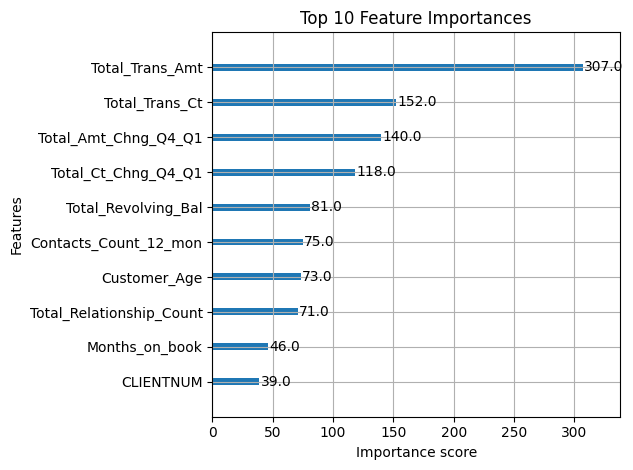

In [13]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


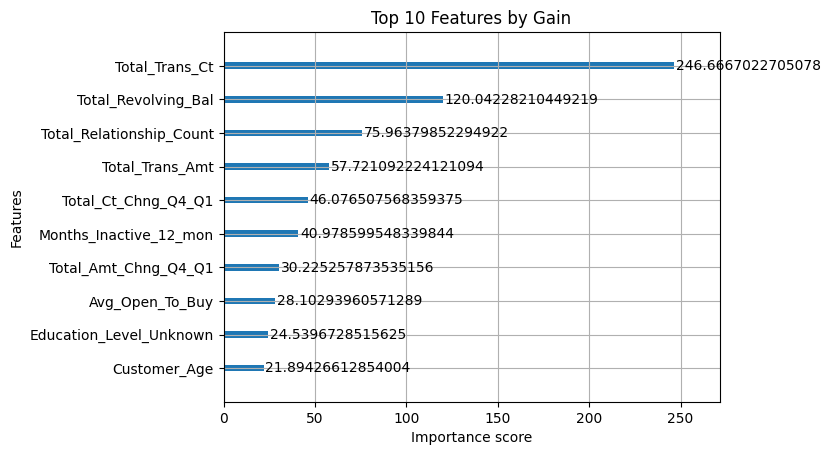

In [14]:
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Features by Gain")
plt.show()


c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


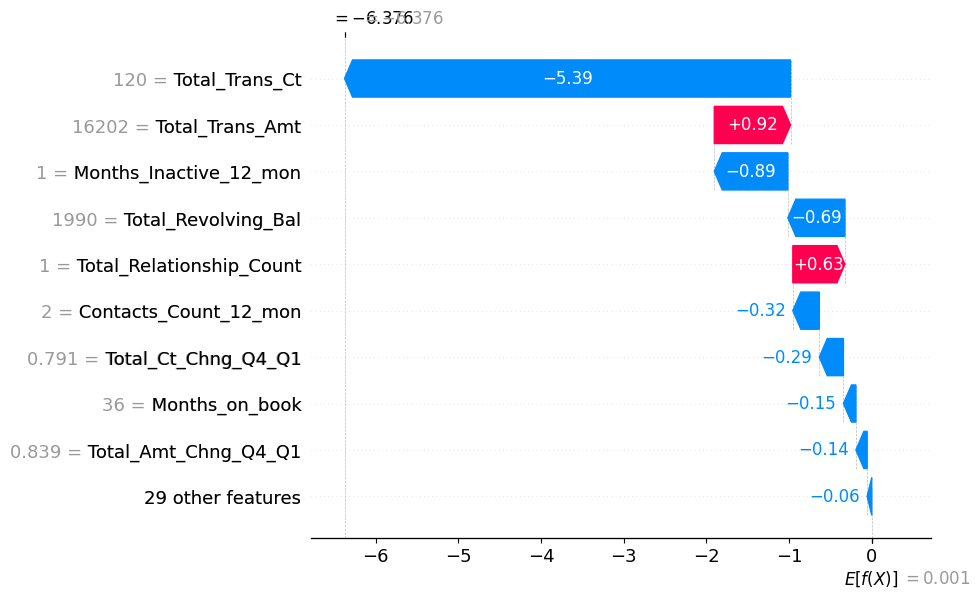

In [15]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 解釋第一筆資料
shap.plots.waterfall(shap_values[0])


## 六、FN分析

In [16]:
# --- 請將此程式碼區塊複製到 Jupyter Notebook 的新 cell 並執行 ---

# 首先，確保必要的函式庫已匯入，且相關變數已定義
# (通常 pandas 和 sklearn.metrics.confusion_matrix 已在您的 notebook 中匯入)
import pandas as pd
from sklearn.metrics import confusion_matrix

# 假設 y_test, y_pred, test_df_encoded, test_df 已經在之前的 cell 中定義並可用

# 再次計算並顯示混淆矩陣，以方便對照 FN 數量
print("重新確認混淆矩陣 (Confusion Matrix):")
cm = confusion_matrix(y_test, y_pred)
print(cm)
fn_count_from_cm = cm[1, 0] # FN 在混淆矩陣中通常是 (row 1, col 0) 當 1 是正面類別時
print(f"從混淆矩陣中讀取的 FN 數量: {fn_count_from_cm}")
print("\\n" + "="*50 + "\\n")

print("## 🧐 False Negative (FN) 資料分析")
print("False Negatives (FN) 是指那些實際上已經流失 (Attrition_Flag = 1)，")
print("但模型卻錯誤地預測為未流失 (Prediction = 0) 的客戶。")
print("深入分析這些 FN 客戶的特徵，有助於我們了解模型在哪些情況下容易犯錯，")
print("從而找到改進模型的方向。")
print("\\n" + "="*50 + "\\n")

# 建立 False Negative 的遮罩
# y_test (實際標籤) 是 Pandas Series。
# y_pred (預測標籤) 是 NumPy array。
# 確保它們可以正確進行元素級比較。
# Attrition_Flag: 1 代表 'Attrited Customer' (流失), 0 代表 'Existing Customer' (未流失)
# FN 條件: y_test == 1 (實際流失) AND y_pred == 0 (預測未流失)
fn_mask = (y_test == 1) & (y_pred == 0)

actual_fn_count = fn_mask.sum()
print(f"透過遮罩計算出的 FN 樣本數量: {actual_fn_count}")

if actual_fn_count != fn_count_from_cm:
    print(f"警告：遮罩計算的 FN ({actual_fn_count}) 與混淆矩陣的 FN ({fn_count_from_cm}) 不符，請檢查！")
print("\\n" + "="*50 + "\\n")

# 使用遮罩從 test_df (原始特徵) 中選出 FN 的客戶資料
# 假設 test_df 的索引與 y_test 的索引一致
fn_customers_original = test_df[fn_mask]

# 使用遮罩從 test_df_encoded (包含 one-hot 特徵) 中選出 FN 的客戶資料
# 假設 test_df_encoded 的索引與 y_test 的索引一致
fn_customers_encoded = test_df_encoded[fn_mask]


print(f"--- 找到 {actual_fn_count} 位 False Negative 客戶的詳細資料 ---")

print("\\n📌 FN 客戶的原始特徵 (來自 test_df):")
if fn_customers_original.empty:
    print("沒有找到 FN 客戶 (基於原始 test_df)。")
else:
    try:
        display(fn_customers_original) # 在 Jupyter 環境中，display() 效果更好
    except NameError: # 如果不在 Jupyter 環境或 display 未定義
        print(fn_customers_original.to_string()) # 打印整個 DataFrame

print("\\n📌 FN 客戶的 CLIENTNUM (通常在原始 test_df 或 test_df_encoded 中):")
if 'CLIENTNUM' in fn_customers_original.columns:
    client_nums = fn_customers_original[['CLIENTNUM']]
elif 'CLIENTNUM' in fn_customers_encoded.columns:
    client_nums = fn_customers_encoded[['CLIENTNUM']]
else:
    client_nums = None

if client_nums is not None and not client_nums.empty:
    try:
        display(client_nums)
    except NameError:
        print(client_nums.to_string())
elif actual_fn_count > 0:
    print("在 FN 客戶資料中未找到 'CLIENTNUM' 欄位。")
else:
    print("因未找到 FN 客戶，無法顯示 CLIENTNUM。")


print("\\n📌 FN 客戶的編碼後特徵 (來自 test_df_encoded):")
if fn_customers_encoded.empty:
    print("沒有找到 FN 客戶 (基於 test_df_encoded)。")
else:
    try:
        display(fn_customers_encoded)
    except NameError:
        print(fn_customers_encoded.to_string())

# --- 程式碼區塊結束 ---

重新確認混淆矩陣 (Confusion Matrix):
[[1632   69]
 [  13  312]]
從混淆矩陣中讀取的 FN 數量: 13
\n==================================================\n
## 🧐 False Negative (FN) 資料分析
False Negatives (FN) 是指那些實際上已經流失 (Attrition_Flag = 1)，
但模型卻錯誤地預測為未流失 (Prediction = 0) 的客戶。
深入分析這些 FN 客戶的特徵，有助於我們了解模型在哪些情況下容易犯錯，
從而找到改進模型的方向。
\n==================================================\n
透過遮罩計算出的 FN 樣本數量: 13
\n==================================================\n
--- 找到 13 位 False Negative 客戶的詳細資料 ---
\n📌 FN 客戶的原始特徵 (來自 test_df):


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
232,713845083,41,F,4,High School,Single,Less than $40K,Blue,36,6,...,3,4203.0,2517,1686.0,0.771,1489,43,0.536,0.599,Attrited Customer
290,719384433,44,F,3,High School,Divorced,Less than $40K,Blue,28,5,...,3,1877.0,1203,674.0,0.654,2581,57,0.781,0.641,Attrited Customer
389,709764483,61,M,1,Graduate,Unknown,$60K - $80K,Blue,53,1,...,2,6157.0,581,5576.0,0.583,4041,65,0.548,0.094,Attrited Customer
499,716924958,65,F,2,Graduate,Single,Less than $40K,Blue,56,3,...,3,6812.0,1926,4886.0,0.735,2288,48,0.778,0.283,Attrited Customer
580,720891633,53,F,2,High School,Single,Less than $40K,Blue,46,6,...,2,3199.0,0,3199.0,1.047,4805,59,0.639,0.000,Attrited Customer
757,710061783,49,M,1,Graduate,Married,$40K - $60K,Blue,40,6,...,4,14973.0,0,14973.0,0.895,4517,59,0.439,0.000,Attrited Customer
758,780584658,33,F,2,Uneducated,Unknown,$40K - $60K,Blue,22,4,...,2,1843.0,1293,550.0,0.349,2077,61,0.694,0.702,Attrited Customer
831,720006333,48,M,2,College,Divorced,$80K - $120K,Blue,40,4,...,3,4479.0,0,4479.0,0.890,4520,63,0.370,0.000,Attrited Customer
876,715328658,41,F,5,Post-Graduate,Married,Less than $40K,Blue,36,5,...,3,1495.0,0,1495.0,0.686,2622,70,0.628,0.000,Attrited Customer
1196,711509658,61,M,2,Graduate,Married,$120K +,Blue,49,3,...,4,11374.0,2517,8857.0,1.015,1088,26,1.167,0.221,Attrited Customer


\n📌 FN 客戶的 CLIENTNUM (通常在原始 test_df 或 test_df_encoded 中):


,CLIENTNUM
232,713845083
290,719384433
389,709764483
499,716924958
580,720891633
757,710061783
758,780584658
831,720006333
876,715328658
1196,711509658


\n📌 FN 客戶的編碼後特徵 (來自 test_df_encoded):


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
232,713845083,41,4,36,6,2,3,4203.0,2517,1686.0,...,False,False,False,False,True,False,True,False,False,False
290,719384433,44,3,28,5,2,3,1877.0,1203,674.0,...,False,False,False,False,True,False,True,False,False,False
389,709764483,61,1,53,1,1,2,6157.0,581,5576.0,...,False,False,True,False,False,False,True,False,False,False
499,716924958,65,2,56,3,0,3,6812.0,1926,4886.0,...,False,False,False,False,True,False,True,False,False,False
580,720891633,53,2,46,6,1,2,3199.0,0,3199.0,...,False,False,False,False,True,False,True,False,False,False
757,710061783,49,1,40,6,1,4,14973.0,0,14973.0,...,False,True,False,False,False,False,True,False,False,False
758,780584658,33,2,22,4,2,2,1843.0,1293,550.0,...,False,True,False,False,False,False,True,False,False,False
831,720006333,48,2,40,4,3,3,4479.0,0,4479.0,...,False,False,False,True,False,False,True,False,False,False
876,715328658,41,5,36,5,3,3,1495.0,0,1495.0,...,False,False,False,False,True,False,True,False,False,False
1196,711509658,61,2,49,3,0,4,11374.0,2517,8857.0,...,True,False,False,False,False,False,True,False,False,False


In [17]:
    # --- 請將此程式碼區塊複製到 Jupyter Notebook 的新 cell 並執行 ---

    # 首先，確保必要的函式庫已匯入，且相關變數已定義
    # (通常 pandas 和 sklearn.metrics.confusion_matrix 已在您的 notebook 中匯入)
    import pandas as pd
    from sklearn.metrics import confusion_matrix

    # 假設 y_test, y_pred, test_df_encoded, test_df 已經在之前的 cell 中定義並可用

    # 再次計算並顯示混淆矩陣，以方便對照 FN 數量
    print("重新確認混淆矩陣 (Confusion Matrix):")
    cm = confusion_matrix(y_test, y_pred) # 確保 y_test, y_pred 已定義
    print(cm)
    fn_count_from_cm = cm[1, 0]
    print(f"從混淆矩陣中讀取的 FN 數量: {fn_count_from_cm}")
    print("\\n" + "="*50 + "\\n")

    # ... (中間的說明文字) ...

    # 建立 False Negative 的遮罩
    fn_mask = (y_test == 1) & (y_pred == 0)
    actual_fn_count = fn_mask.sum()
    print(f"透過遮罩計算出的 FN 樣本數量: {actual_fn_count}")

    # ... (檢查 FN 數量是否與 cm 一致的程式碼) ...

    # 使用遮罩從 test_df (原始特徵) 中選出 FN 的客戶資料
    # 確保 test_df 已定義
    fn_customers_original = test_df[fn_mask]

    # 使用遮罩從 test_df_encoded (包含 one-hot 特徵) 中選出 FN 的客戶資料
    # 確保 test_df_encoded 已定義
    fn_customers_encoded = test_df_encoded[fn_mask]

    print(f"--- 找到 {actual_fn_count} 位 False Negative 客戶的詳細資料 ---")
    # ... (後續的 display/print 語句) ...

重新確認混淆矩陣 (Confusion Matrix):
[[1632   69]
 [  13  312]]
從混淆矩陣中讀取的 FN 數量: 13
\n==================================================\n
透過遮罩計算出的 FN 樣本數量: 13
--- 找到 13 位 False Negative 客戶的詳細資料 ---


開始分析 13 位 False Negative 客戶的特徵...

--- 數值型特徵分佈比較 (FN vs 整體測試集) ---


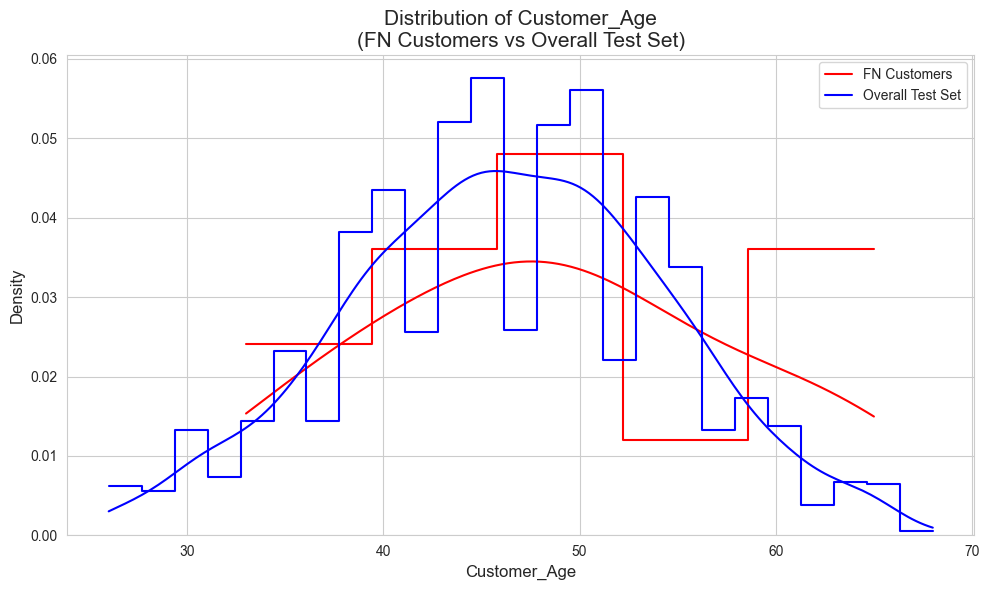

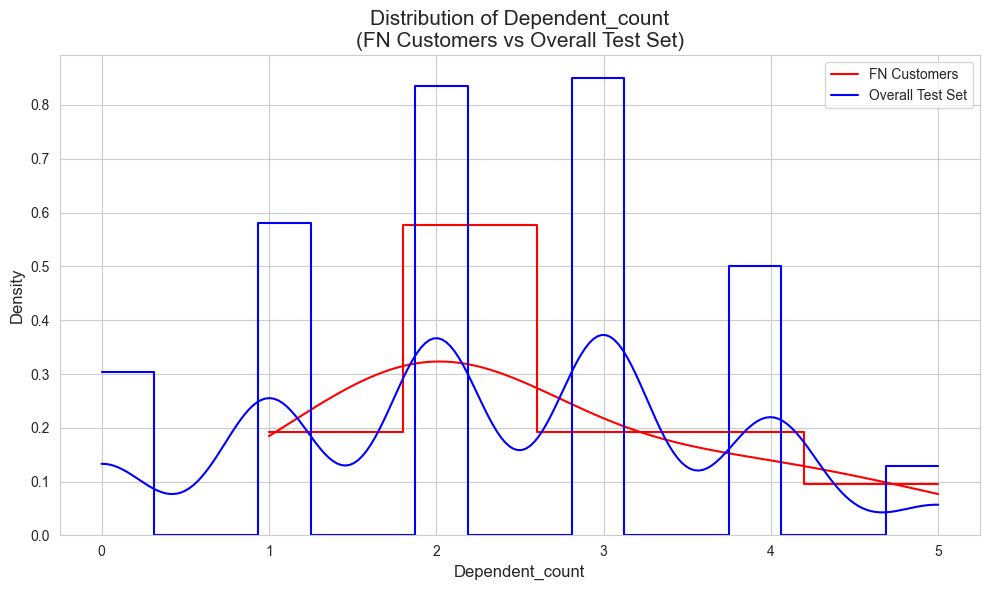

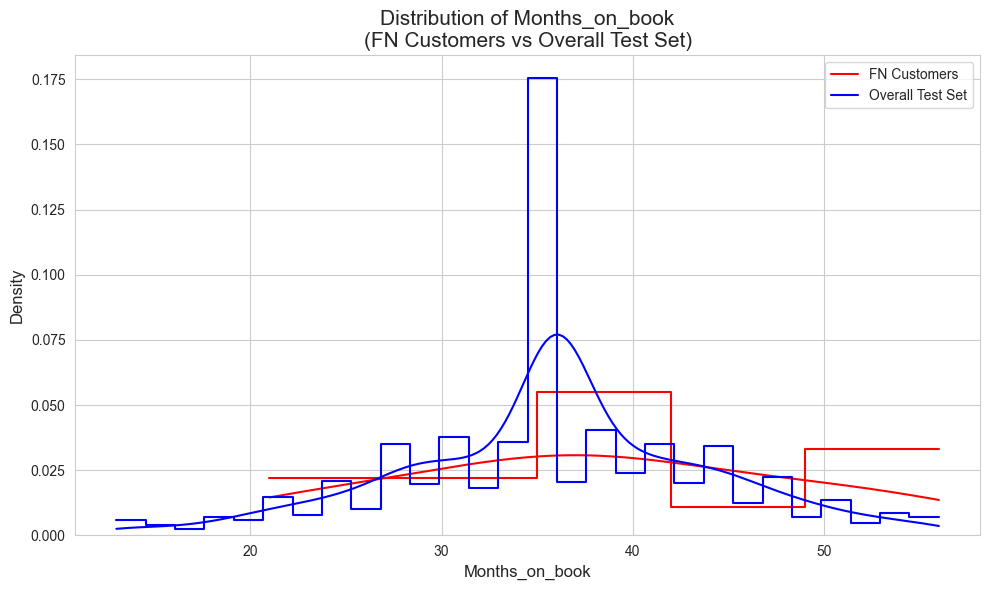

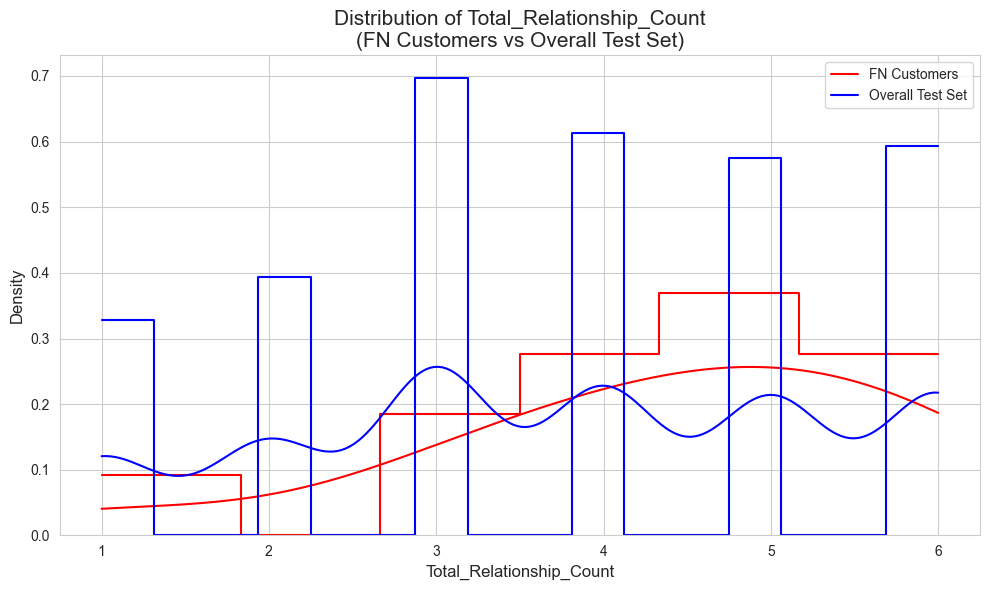

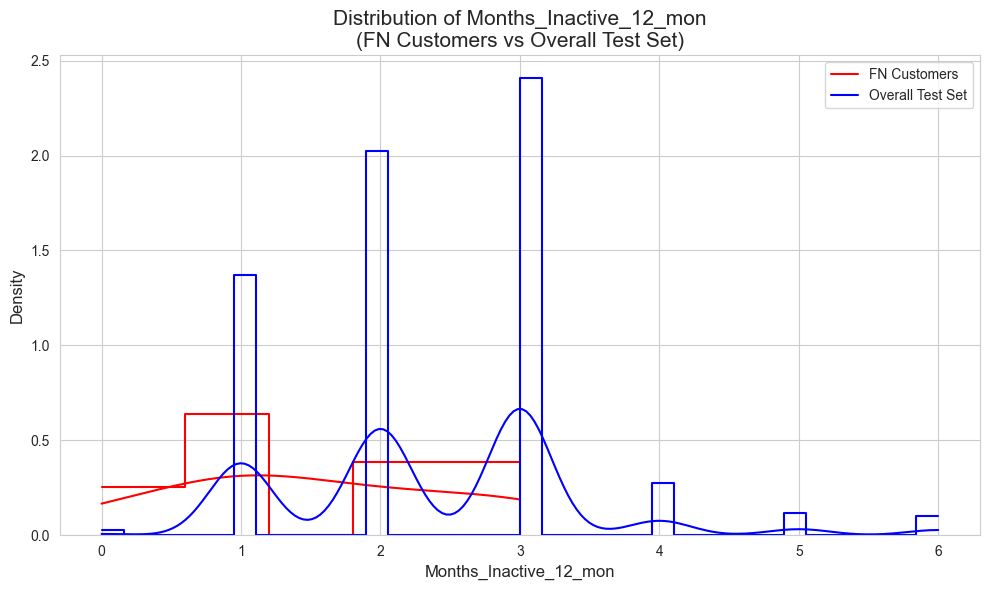

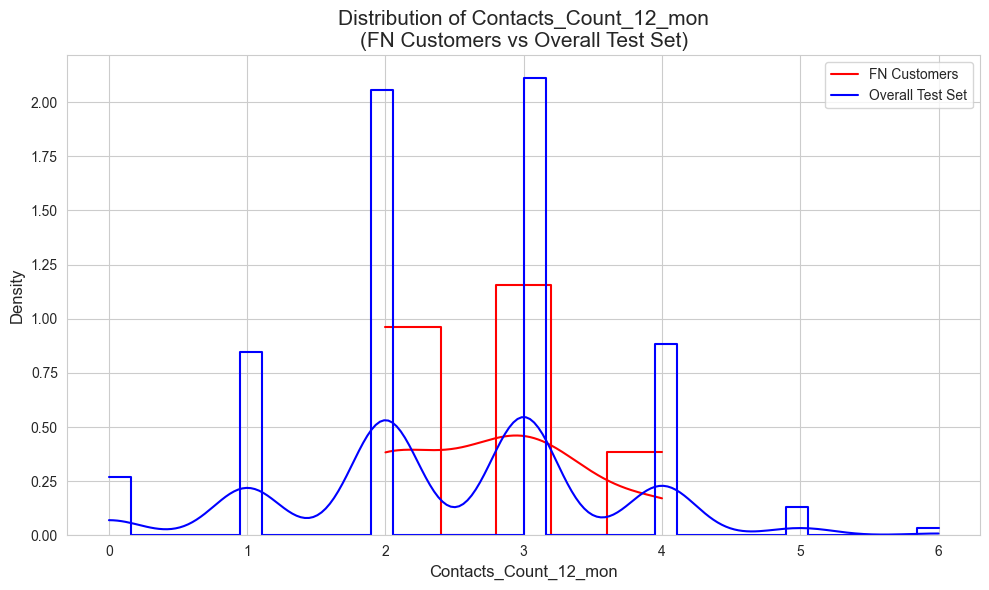

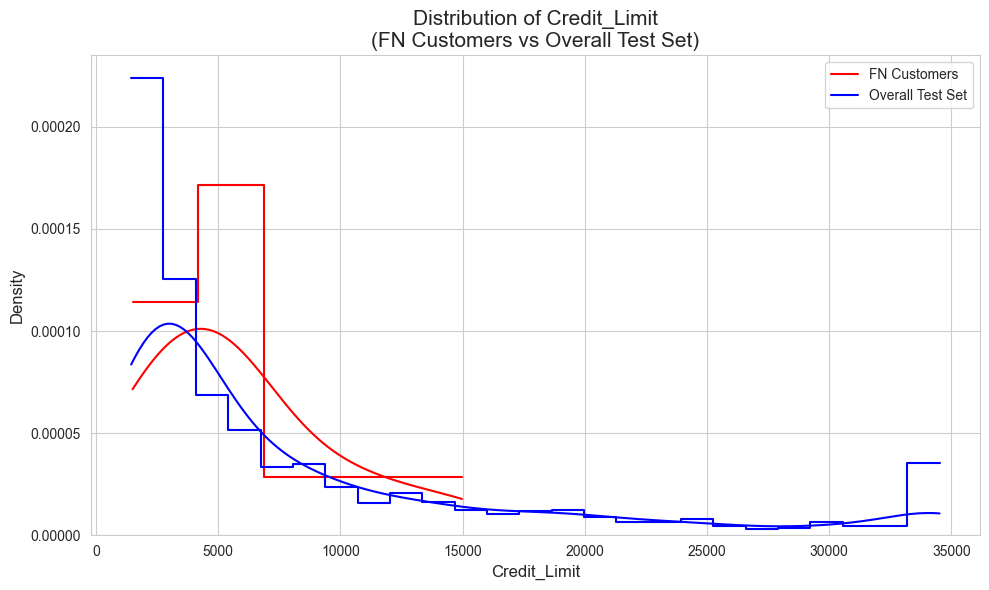

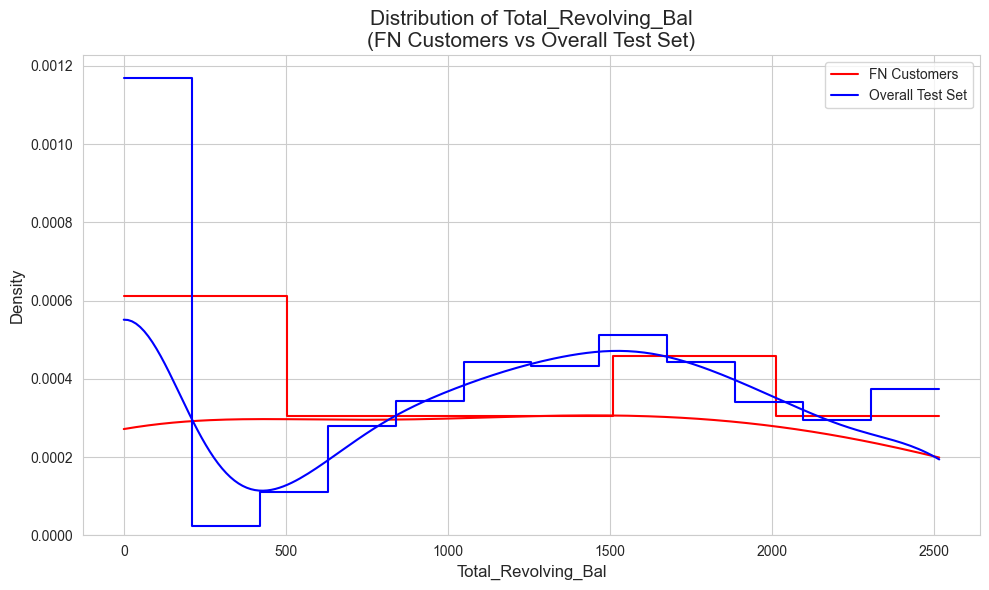

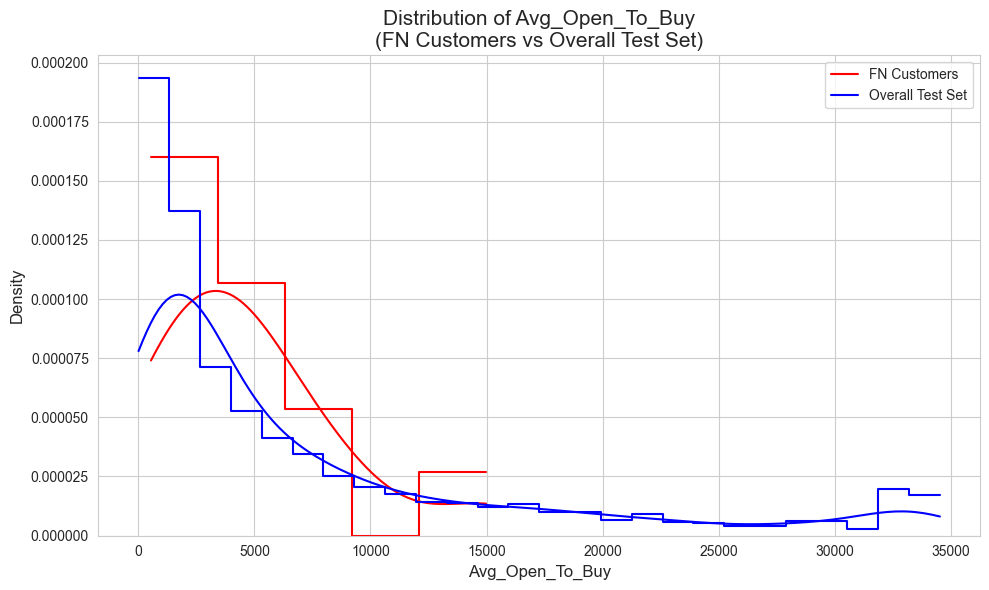

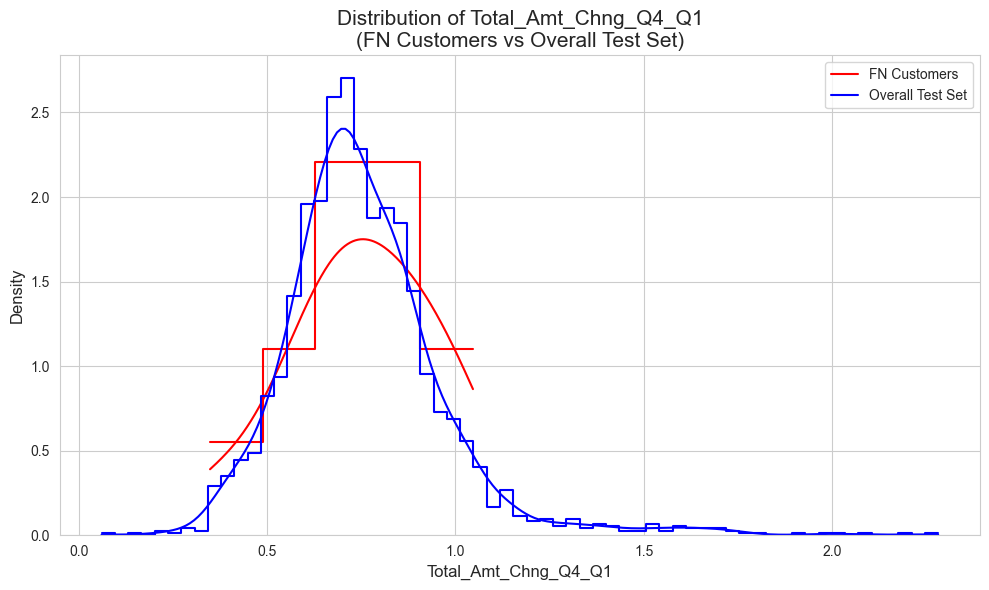

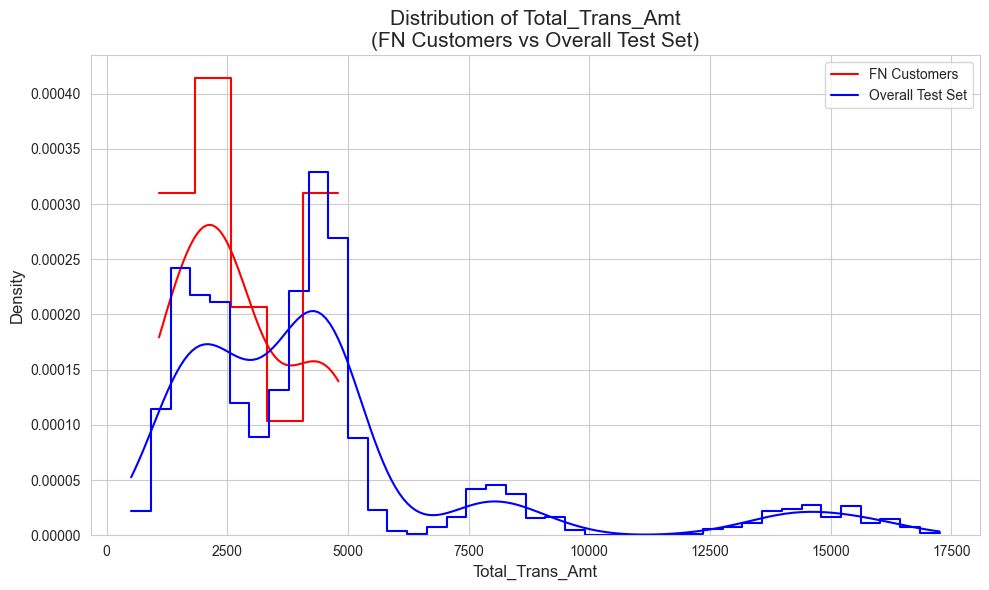

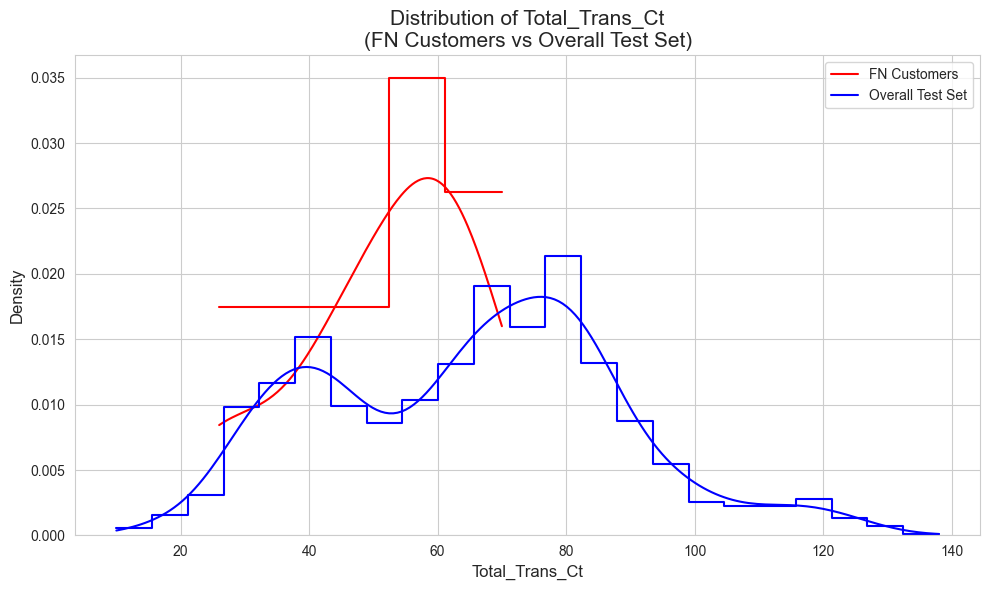

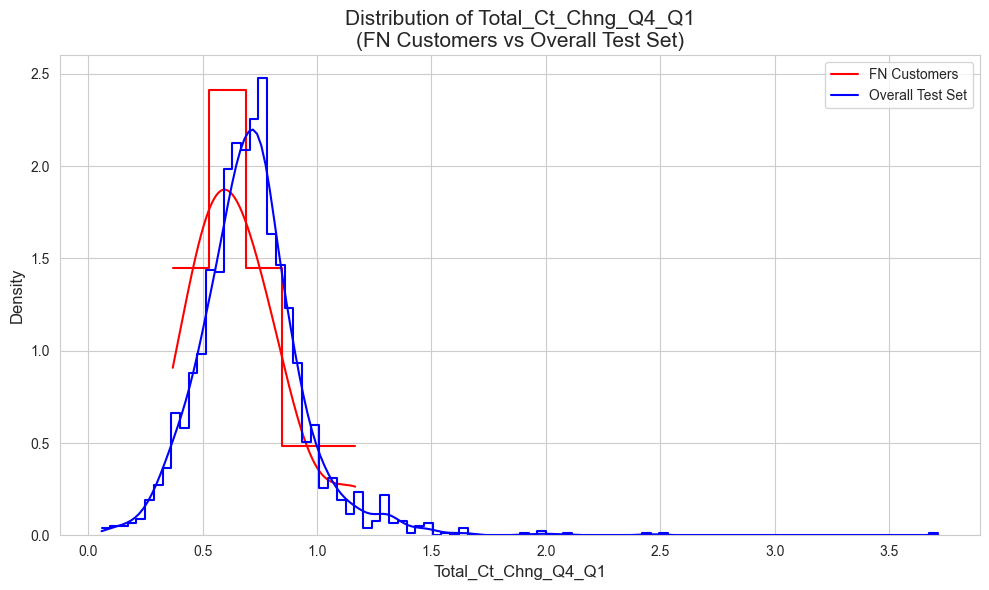

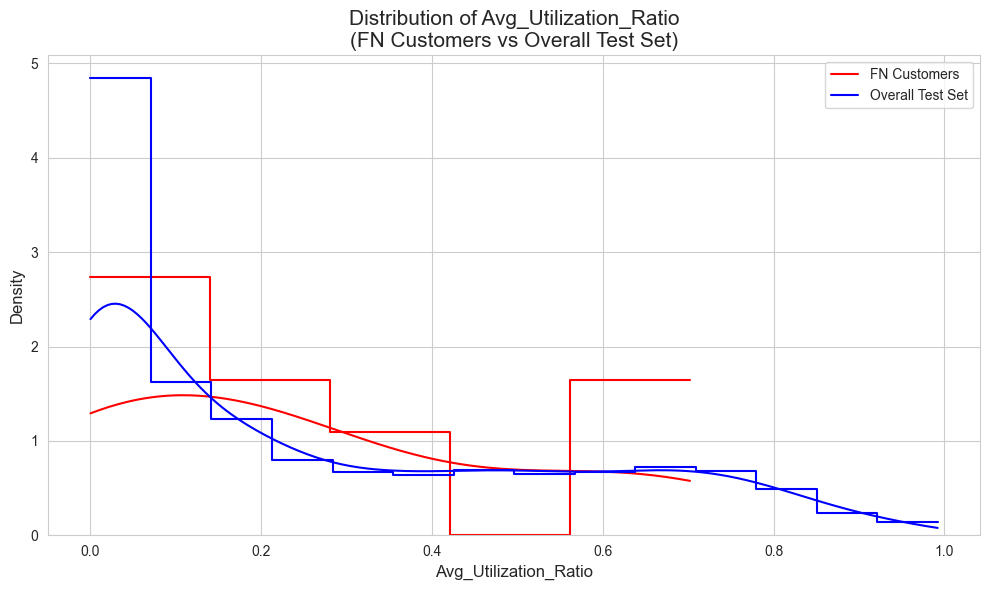



--- 類別型特徵比例比較 (FN vs 整體測試集) ---


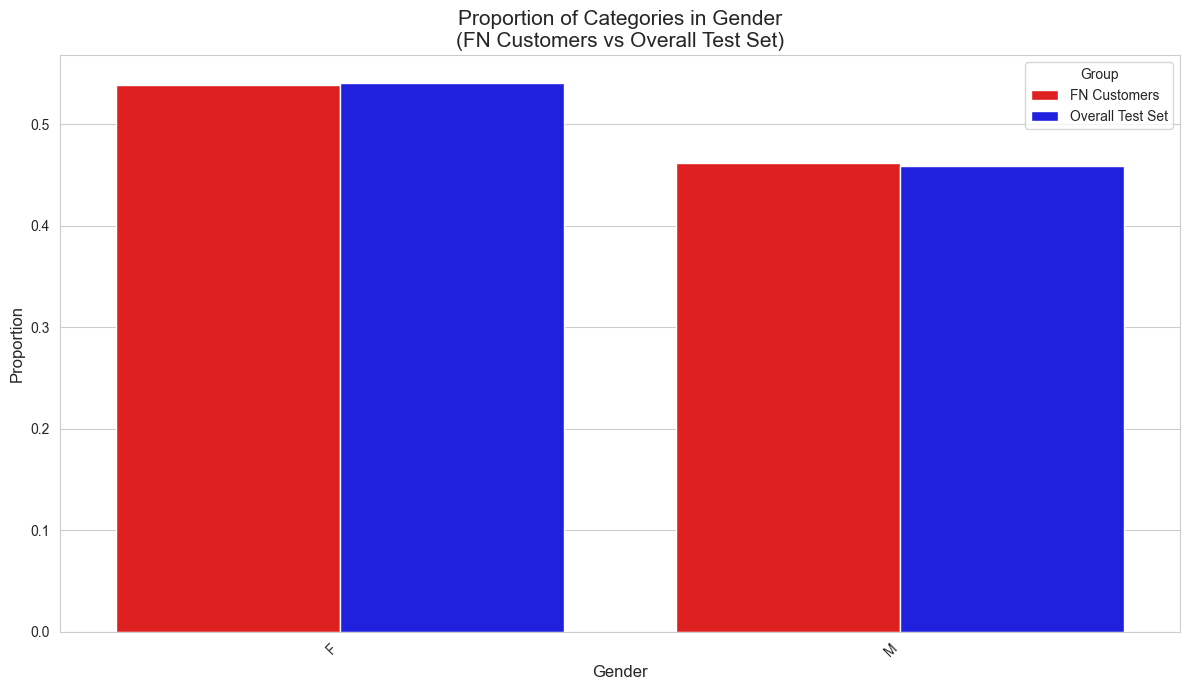

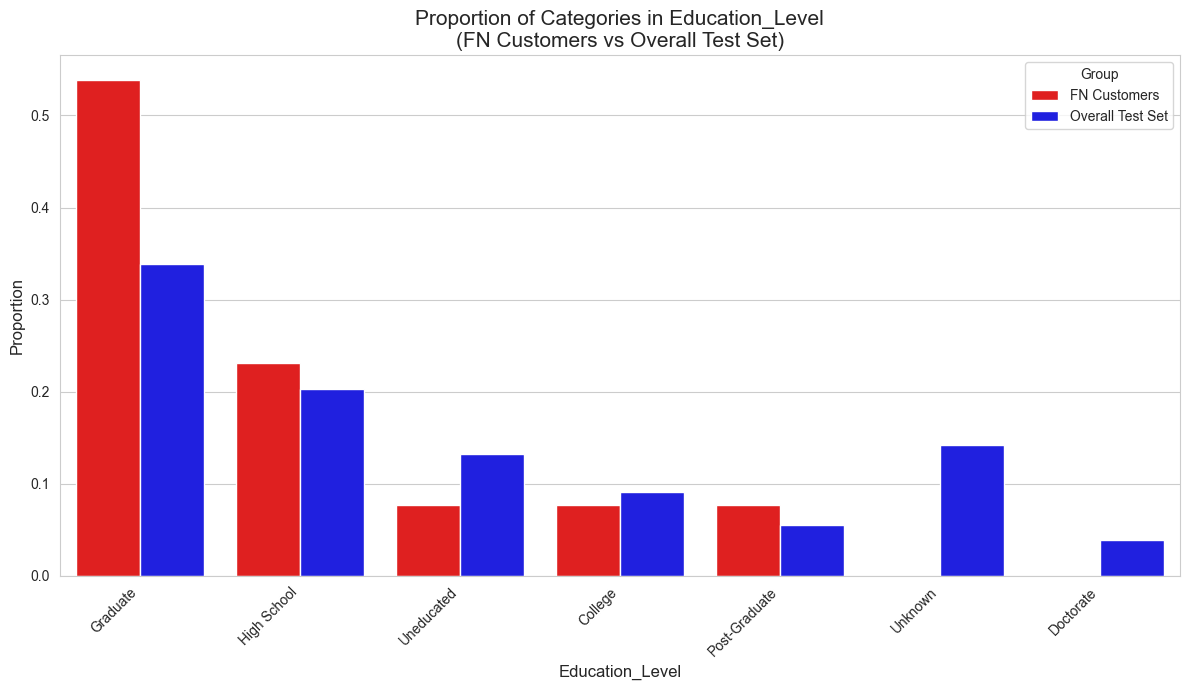

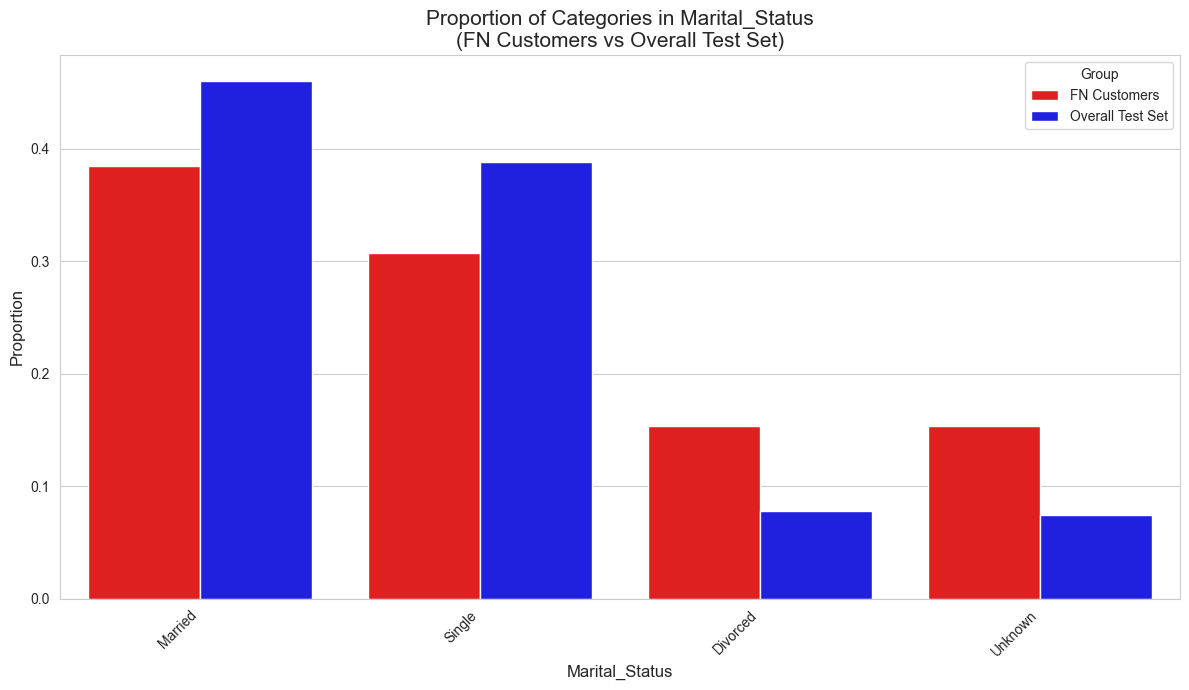

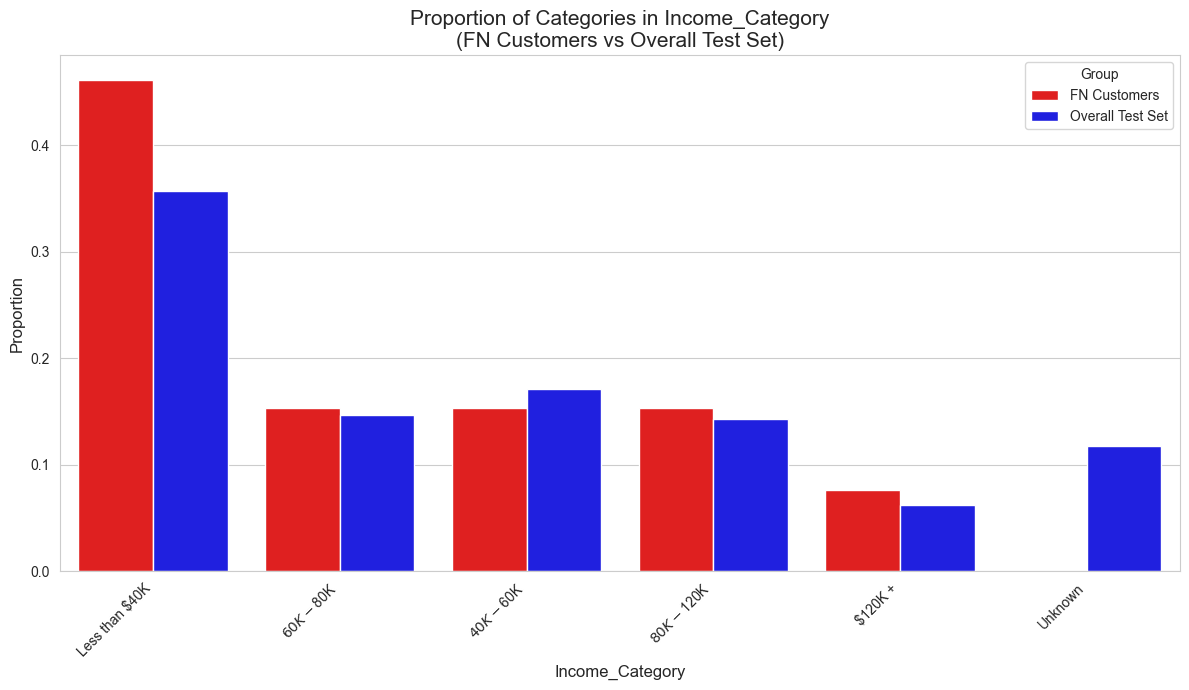

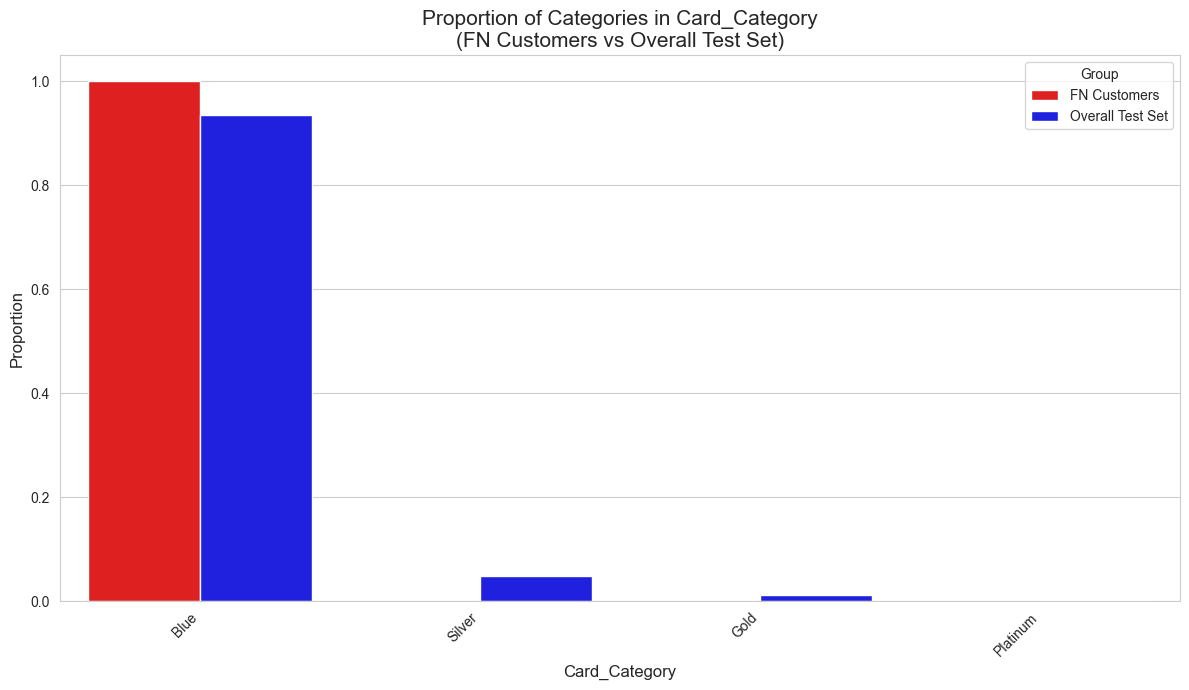



特徵繪圖完成。


In [19]:
# --- 請將此程式碼區塊複製到 Jupyter Notebook 的新 cell 並執行 ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 設定繪圖風格
sns.set_style("whitegrid")

# 假設 fn_customers_original 和 test_df 已經在之前的 cell 中定義並可用
# fn_customers_original: DataFrame 包含 False Negative 客戶的原始特徵
# test_df: DataFrame 包含完整測試集的原始特徵

if 'fn_customers_original' not in locals() or fn_customers_original.empty:
    print("錯誤：'fn_customers_original' DataFrame 未定義或為空。請先確保已成功提取 FN 資料。")
else:
    print(f"開始分析 {fn_customers_original.shape[0]} 位 False Negative 客戶的特徵...\n")

    # 獲取用於繪圖的欄位列表，排除 CLIENTNUM 和 Attrition_Flag
    columns_to_plot = [col for col in fn_customers_original.columns if col not in ['CLIENTNUM', 'Attrition_Flag']]

    # 分離數值型和類別型欄位
    numerical_cols = fn_customers_original[columns_to_plot].select_dtypes(include=['number']).columns.tolist()
    categorical_cols = fn_customers_original[columns_to_plot].select_dtypes(include=['object', 'category']).columns.tolist()

    print("--- 數值型特徵分佈比較 (FN vs 整體測試集) ---")
    if not numerical_cols:
        print("在 FN 資料中未找到數值型特徵可供繪圖。")
    else:
        for col in numerical_cols:
            plt.figure(figsize=(10, 6))

            # 繪製 FN 客戶的直方圖與 KDE
            sns.histplot(fn_customers_original[col], color="red", label='FN Customers', kde=True, stat="density", common_norm=False, element="step", fill=False)

            # 繪製整體測試集客戶的直方圖與 KDE
            sns.histplot(test_df[col], color="blue", label='Overall Test Set', kde=True, stat="density", common_norm=False, element="step", fill=False)

            plt.title(f'Distribution of {col}\n(FN Customers vs Overall Test Set)', fontsize=15)
            plt.xlabel(col, fontsize=12)
            plt.ylabel('Density', fontsize=12)
            plt.legend()
            plt.tight_layout() # 自動調整子圖參數，使之相應地填充整個圖像區域
            plt.show()
        print("\n")

    print("--- 類別型特徵比例比較 (FN vs 整體測試集) ---")
    if not categorical_cols:
        print("在 FN 資料中未找到類別型特徵可供繪圖。")
    else:
        for col in categorical_cols:
            # 計算 FN 客戶中各類別的比例
            fn_prop = fn_customers_original[col].value_counts(normalize=True).reset_index()
            fn_prop.columns = [col, 'Proportion']
            fn_prop['Group'] = 'FN Customers'

            # 計算整體測試集客戶中各類別的比例
            test_prop = test_df[col].value_counts(normalize=True).reset_index()
            test_prop.columns = [col, 'Proportion']
            test_prop['Group'] = 'Overall Test Set'

            # 合併數據以便繪圖
            combined_prop = pd.concat([fn_prop, test_prop], axis=0)

            plt.figure(figsize=(12, 7)) # 稍微調整圖像大小以容納更長的類別標籤
            sns.barplot(x=col, y='Proportion', hue='Group', data=combined_prop, palette={'FN Customers': 'red', 'Overall Test Set': 'blue'})

            plt.title(f'Proportion of Categories in {col}\n(FN Customers vs Overall Test Set)', fontsize=15)
            plt.xlabel(col, fontsize=12)
            plt.ylabel('Proportion', fontsize=12)
            plt.xticks(rotation=45, ha='right') # 旋轉X軸標籤以防重疊
            plt.legend(title='Group')
            plt.tight_layout()
            plt.show()
        print("\n")

    print("特徵繪圖完成。")

# --- 程式碼區塊結束 ---


開始分析 13 位 False Negative (FN) 客戶的特徵...

找到 312 位 True Positive (TP) 客戶。

將比較 FN 客戶與 TP 客戶的特徵分佈。

--- 數值型特徵分佈比較 (FN vs TP) ---


C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


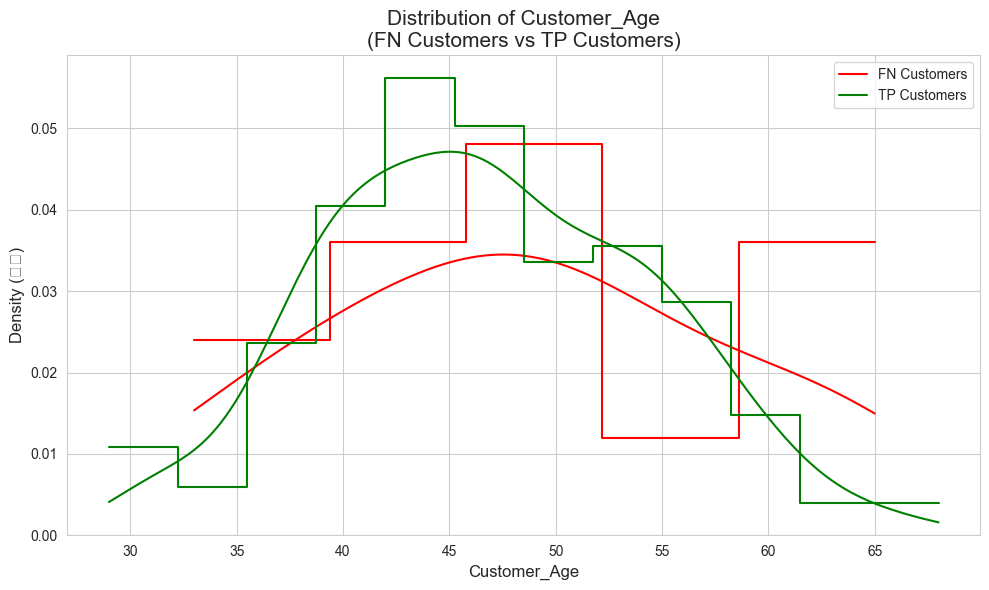

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


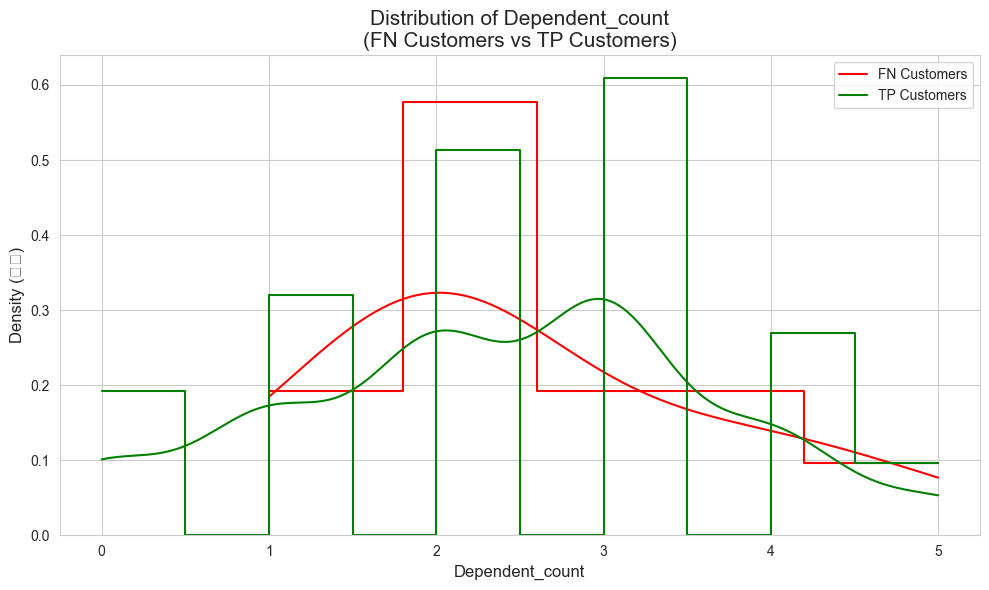

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


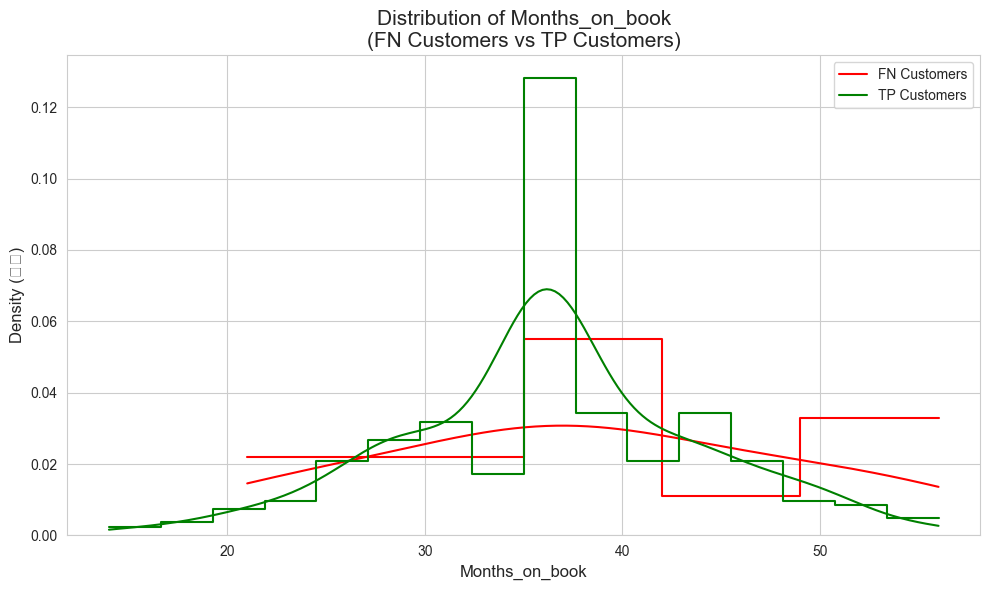

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


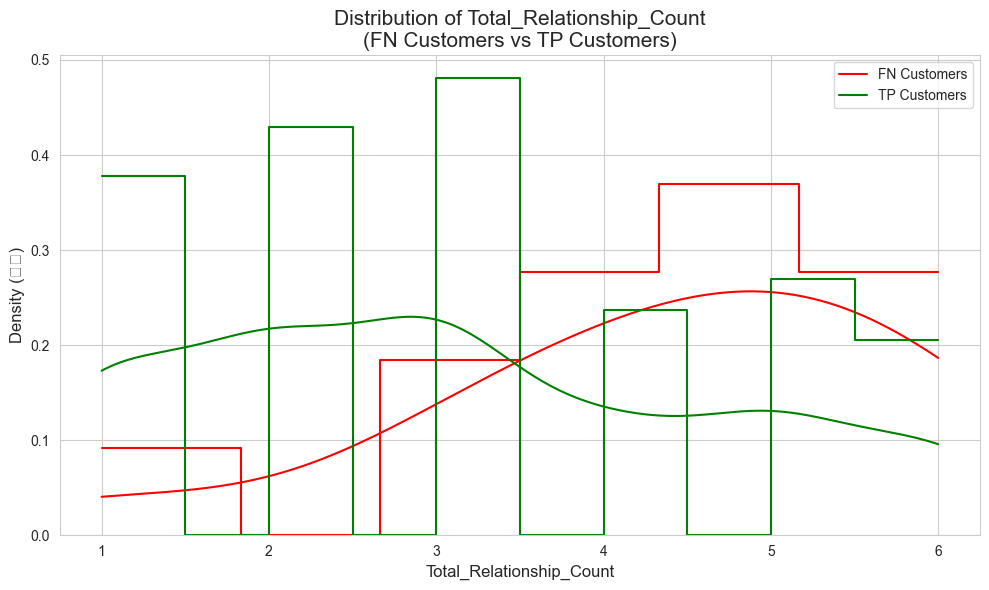

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


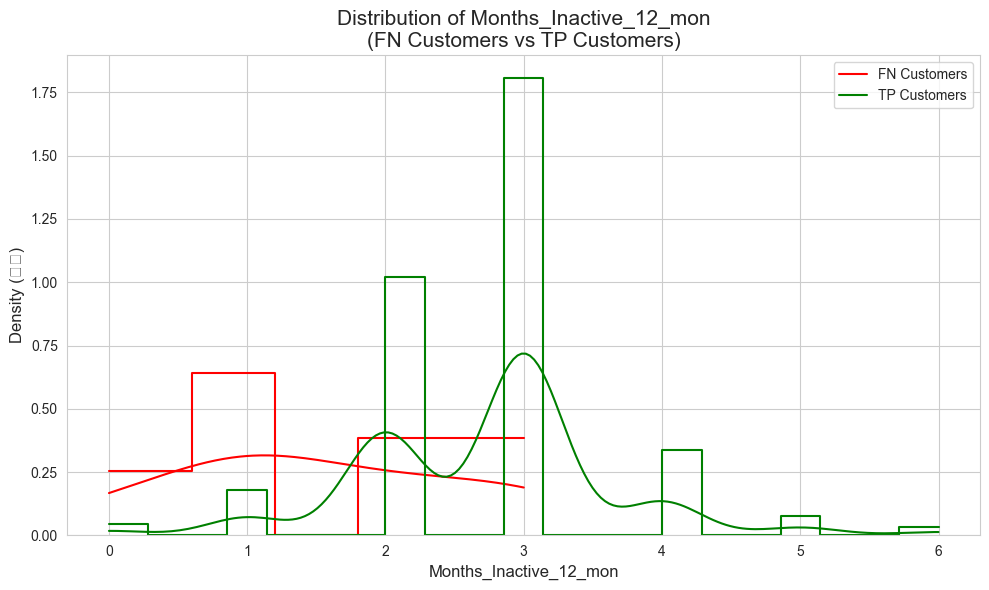

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


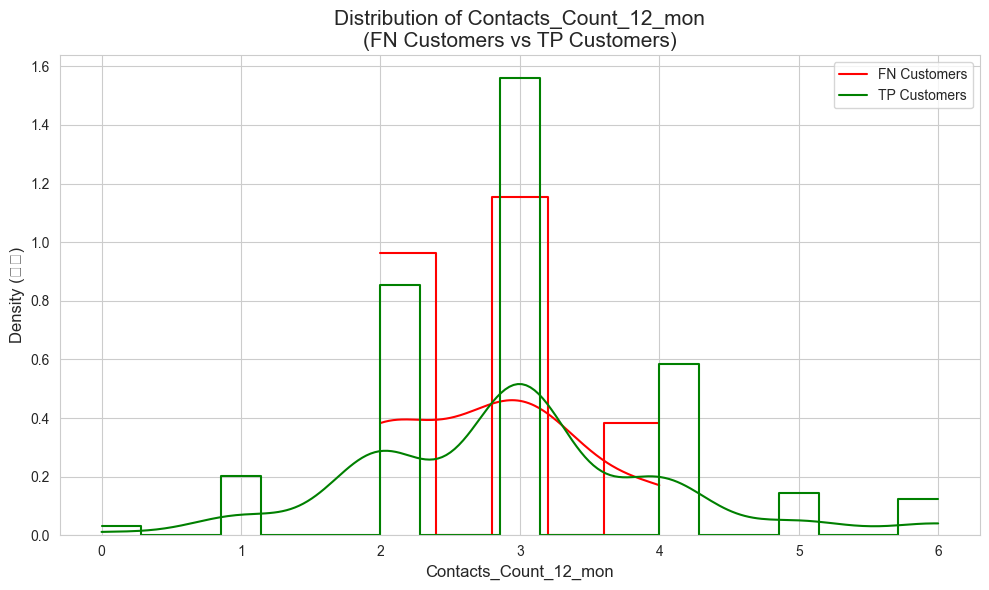

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


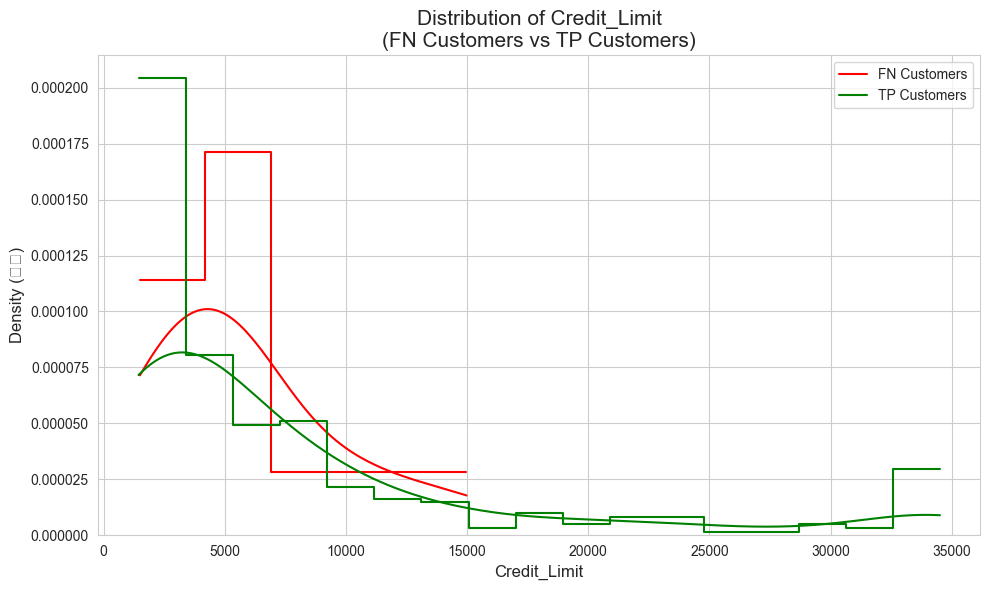

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


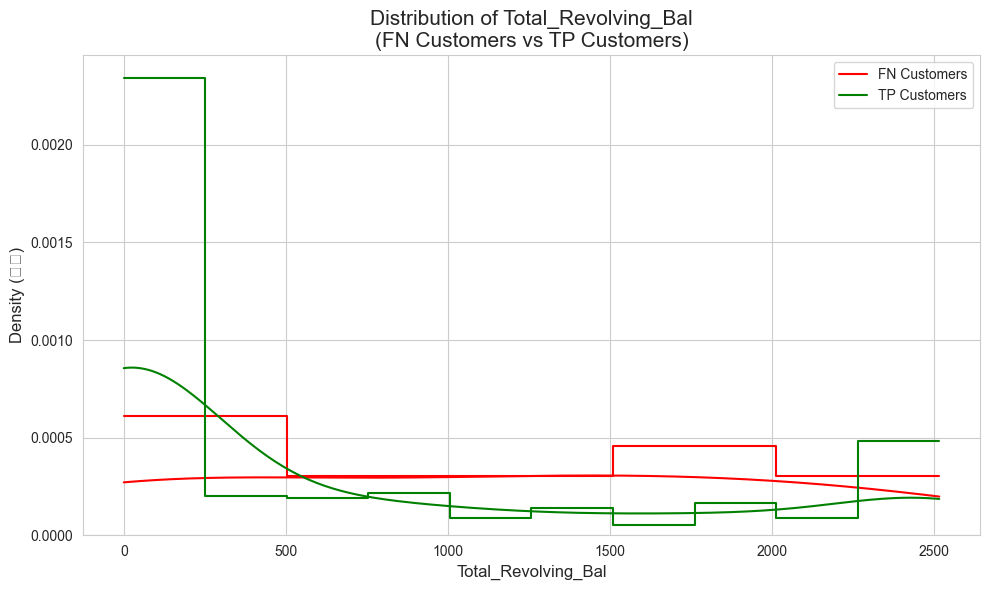

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


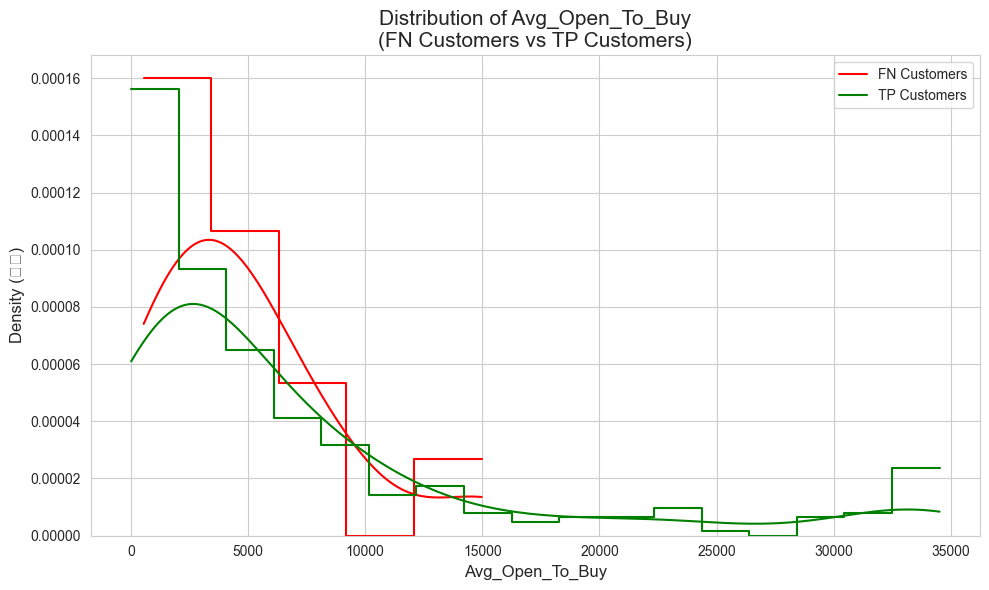

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


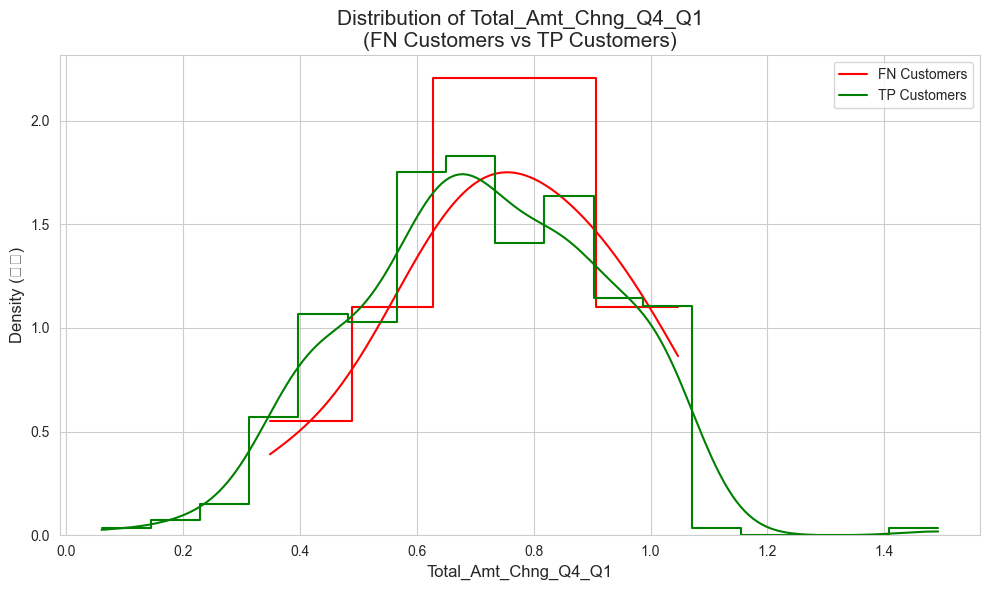

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


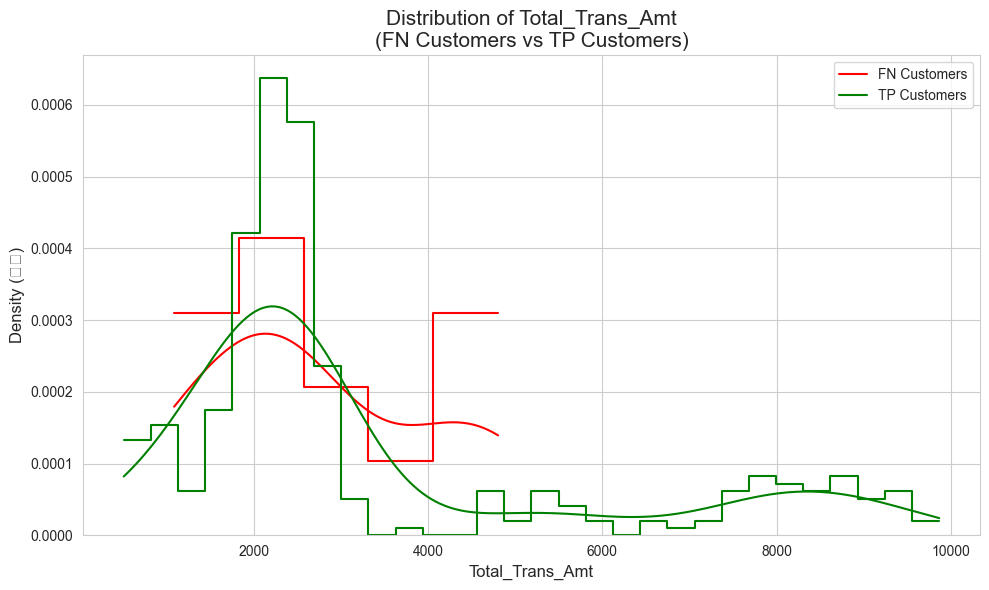

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


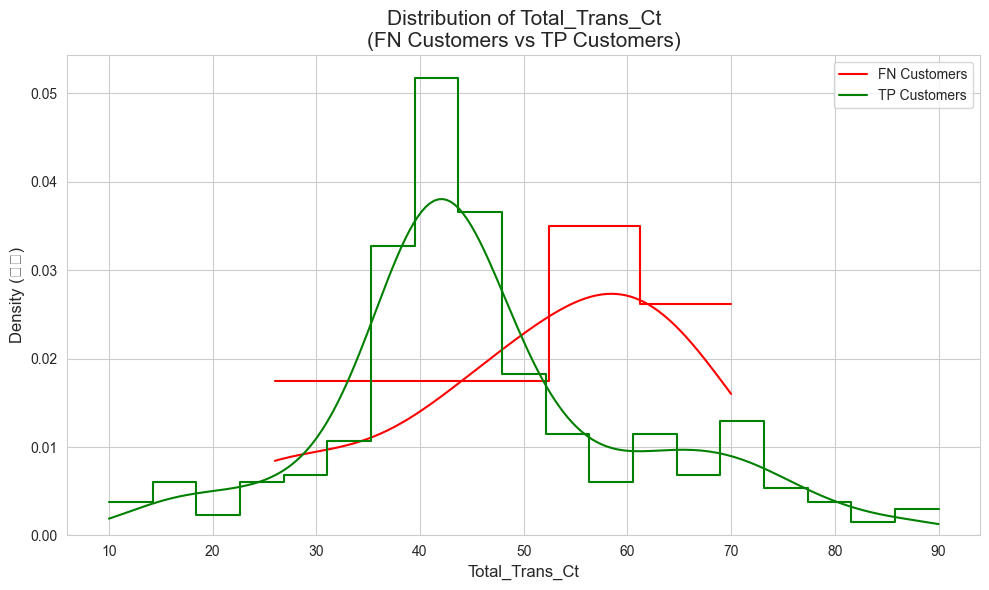

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


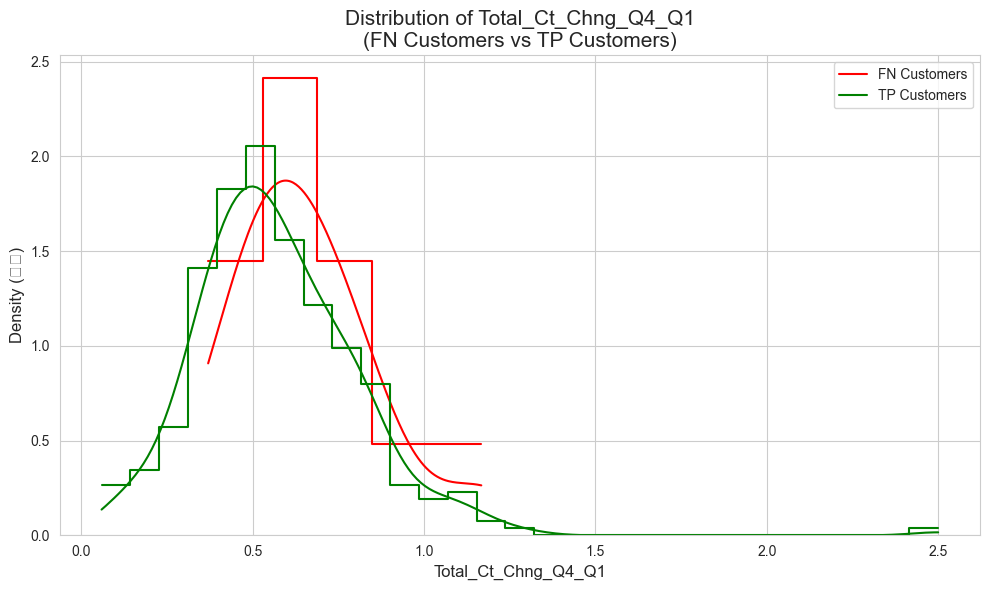

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


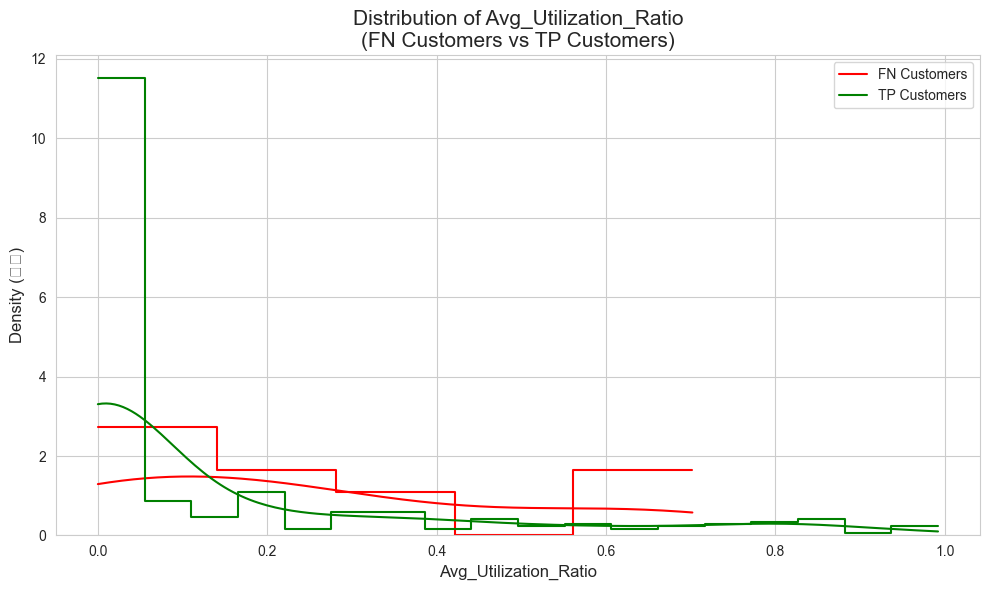



--- 類別型特徵比例比較 (FN vs TP) ---


C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


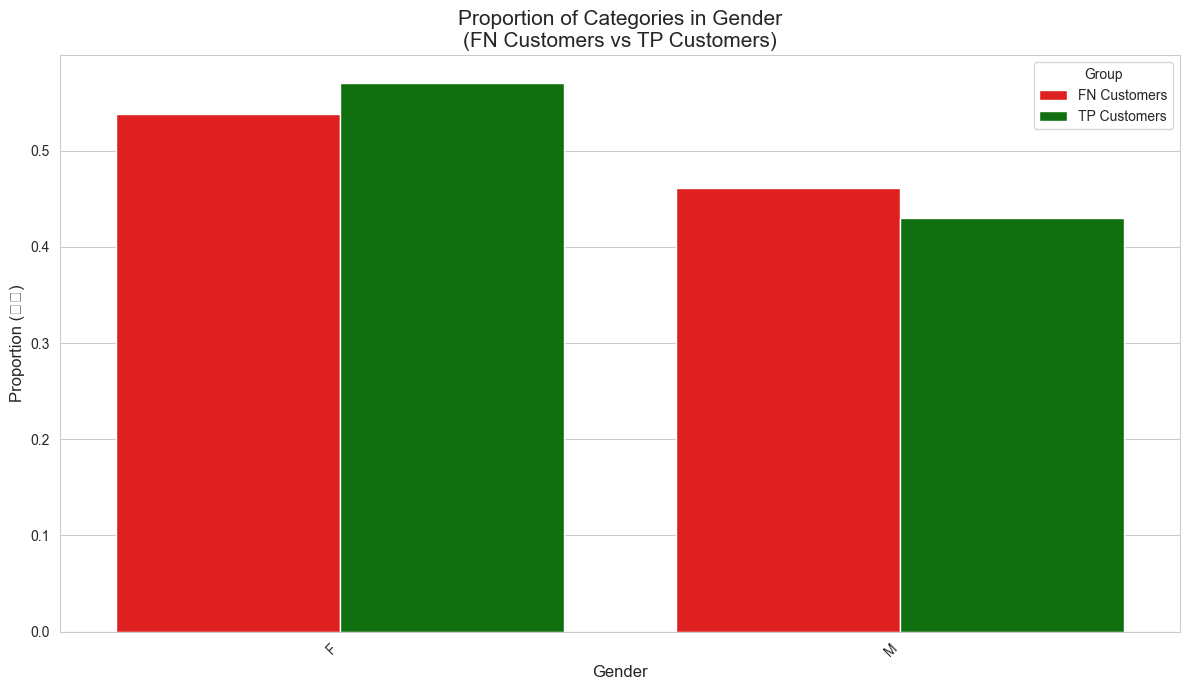

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


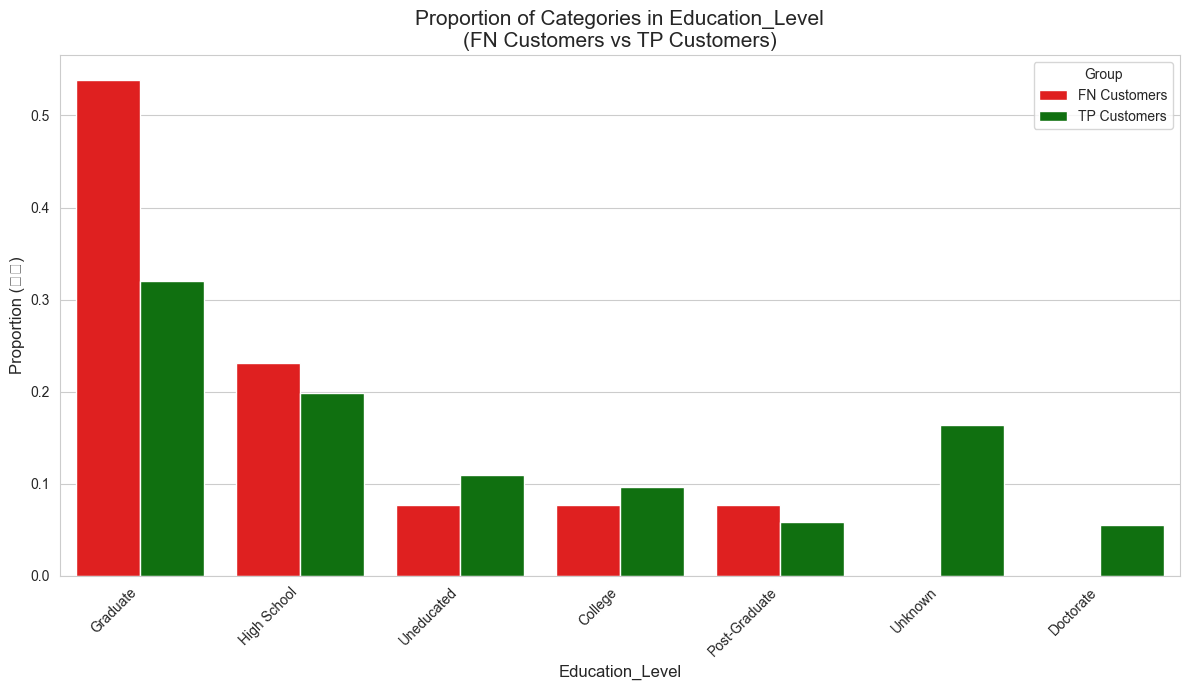

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


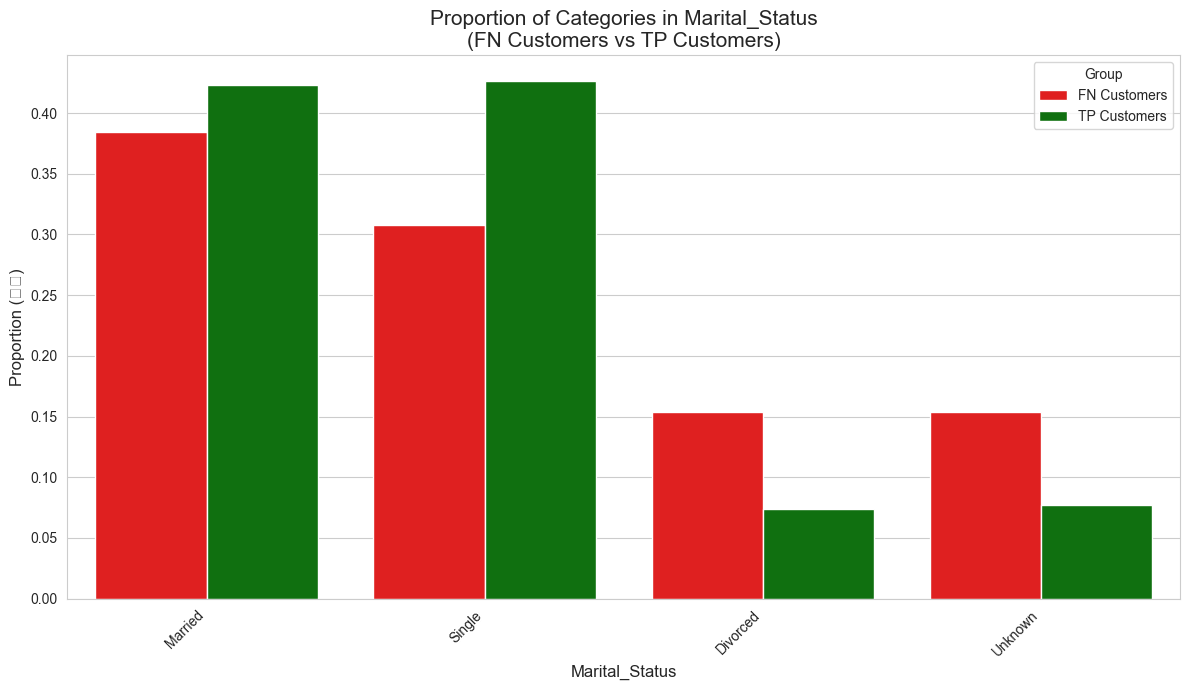

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


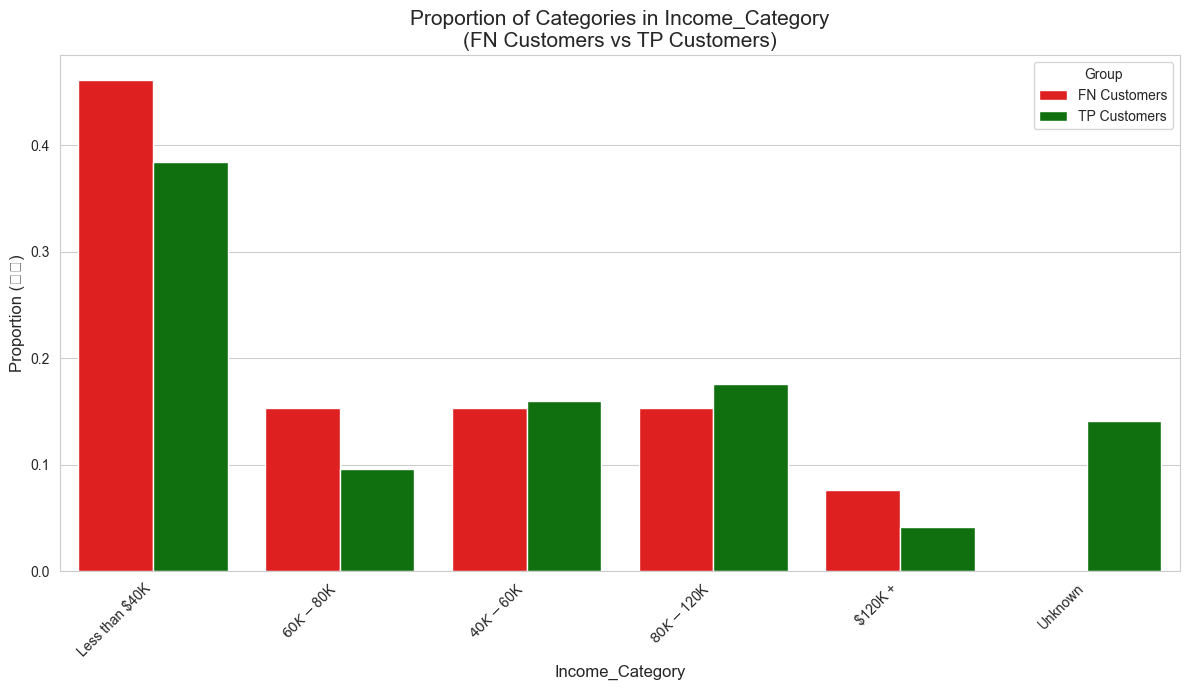

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\173564224.py:87: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


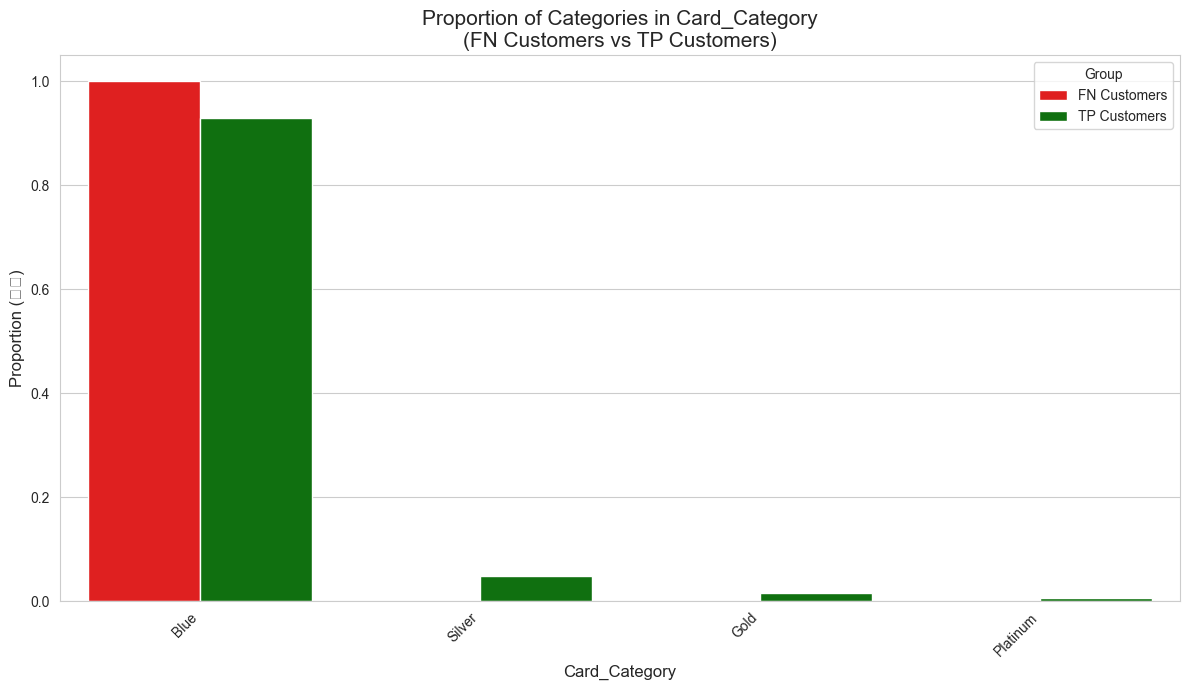



FN 與 TP 特徵比較繪圖完成。


In [20]:
# --- 請將此程式碼區塊複製到 Jupyter Notebook 的新 cell 並執行 ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 設定繪圖風格
sns.set_style("whitegrid")

# 假設 fn_customers_original, y_test, y_pred, 和 test_df 已經在之前的 cell 中定義並可用
# fn_customers_original: DataFrame 包含 False Negative 客戶的原始特徵
# y_test: Series 包含測試集的真實標籤
# y_pred: array 包含模型對測試集的預測標籤
# test_df: DataFrame 包含完整測試集的原始特徵

if 'fn_customers_original' not in locals() or fn_customers_original.empty:
    print("錯誤：'fn_customers_original' DataFrame 未定義或為空。請先確保已成功提取 FN 資料。")
elif 'y_test' not in locals() or 'y_pred' not in locals() or 'test_df' not in locals():
    print("錯誤：'y_test', 'y_pred', 或 'test_df' 未定義。請確保這些變數可用。")
else:
    print(f"開始分析 {fn_customers_original.shape[0]} 位 False Negative (FN) 客戶的特徵...\n")

    # 1. 識別 True Positives (TP)
    # TP: y_test == 1 (實際流失) AND y_pred == 1 (預測流失)
    tp_mask = (y_test == 1) & (y_pred == 1)
    tp_customers_original = test_df[tp_mask]

    if tp_customers_original.empty:
        print("注意：未能找到 True Positive (TP) 客戶。無法進行 FN 與 TP 的比較。")
        print("請檢查您的模型預測或資料。")
    else:
        print(f"找到 {tp_customers_original.shape[0]} 位 True Positive (TP) 客戶。\n")
        print("將比較 FN 客戶與 TP 客戶的特徵分佈。\n")

        # 獲取用於繪圖的欄位列表，排除 CLIENTNUM 和 Attrition_Flag
        columns_to_plot = [col for col in fn_customers_original.columns if col not in ['CLIENTNUM', 'Attrition_Flag']]

        # 分離數值型和類別型欄位
        numerical_cols = fn_customers_original[columns_to_plot].select_dtypes(include=['number']).columns.tolist()
        categorical_cols = fn_customers_original[columns_to_plot].select_dtypes(include=['object', 'category']).columns.tolist()

        print("--- 數值型特徵分佈比較 (FN vs TP) ---")
        if not numerical_cols:
            print("在 FN/TP 資料中未找到數值型特徵可供繪圖。")
        else:
            for col in numerical_cols:
                plt.figure(figsize=(10, 6))

                # 繪製 FN 客戶的直方圖與 KDE (y軸為密度)
                sns.histplot(fn_customers_original[col], color="red", label='FN Customers', kde=True, stat="density", common_norm=False, element="step", fill=False)
                # 繪製 TP 客戶的直方圖與 KDE (y軸為密度)
                sns.histplot(tp_customers_original[col], color="green", label='TP Customers', kde=True, stat="density", common_norm=False, element="step", fill=False)

                plt.title(f'Distribution of {col}\n(FN Customers vs TP Customers)', fontsize=15)
                plt.xlabel(col, fontsize=12)
                plt.ylabel('Density (密度)', fontsize=12) # y軸標示為密度
                plt.legend()
                plt.tight_layout()
                plt.show()
            print("\n")

        print("--- 類別型特徵比例比較 (FN vs TP) ---")
        if not categorical_cols:
            print("在 FN/TP 資料中未找到類別型特徵可供繪圖。")
        else:
            for col in categorical_cols:
                # FN 客戶比例
                fn_prop = fn_customers_original[col].value_counts(normalize=True).reset_index()
                fn_prop.columns = [col, 'Proportion']
                fn_prop['Group'] = 'FN Customers'

                # TP 客戶比例
                tp_prop = tp_customers_original[col].value_counts(normalize=True).reset_index()
                tp_prop.columns = [col, 'Proportion']
                tp_prop['Group'] = 'TP Customers'

                combined_prop = pd.concat([fn_prop, tp_prop], axis=0)

                plt.figure(figsize=(12, 7))
                # 繪製條形圖 (y軸為比例)
                sns.barplot(x=col, y='Proportion', hue='Group', data=combined_prop, palette={'FN Customers': 'red', 'TP Customers': 'green'})

                plt.title(f'Proportion of Categories in {col}\n(FN Customers vs TP Customers)', fontsize=15)
                plt.xlabel(col, fontsize=12)
                plt.ylabel('Proportion (比例)', fontsize=12) # y軸標示為比例
                plt.xticks(rotation=45, ha='right')
                plt.legend(title='Group')
                plt.tight_layout()
                plt.show()
            print("\n")

        print("FN 與 TP 特徵比較繪圖完成。")

# --- 程式碼區塊結束 ---

找到 13 位 False Negative (FN) 客戶。
找到 312 位 True Positive (TP) 客戶。
找到 69 位 False Positive (FP) 客戶。

將比較 FN, TP, 與 FP 客戶的特徵分佈。

--- 數值型特徵分佈比較 (FN vs TP vs FP) ---


C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


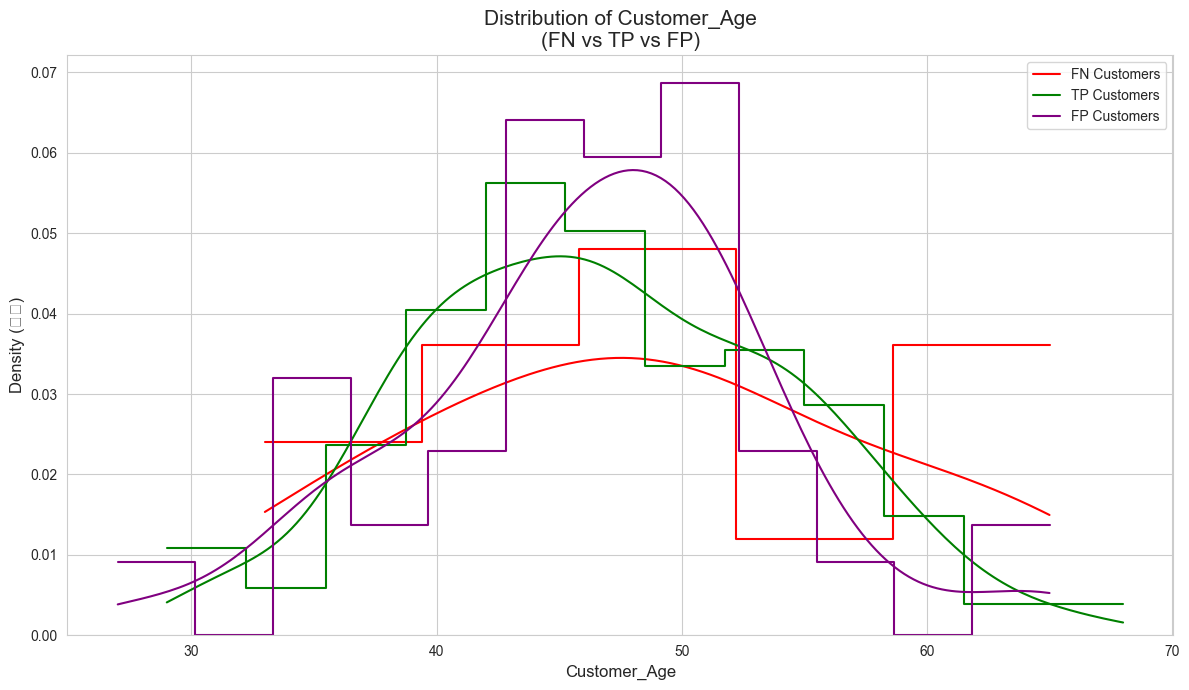

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


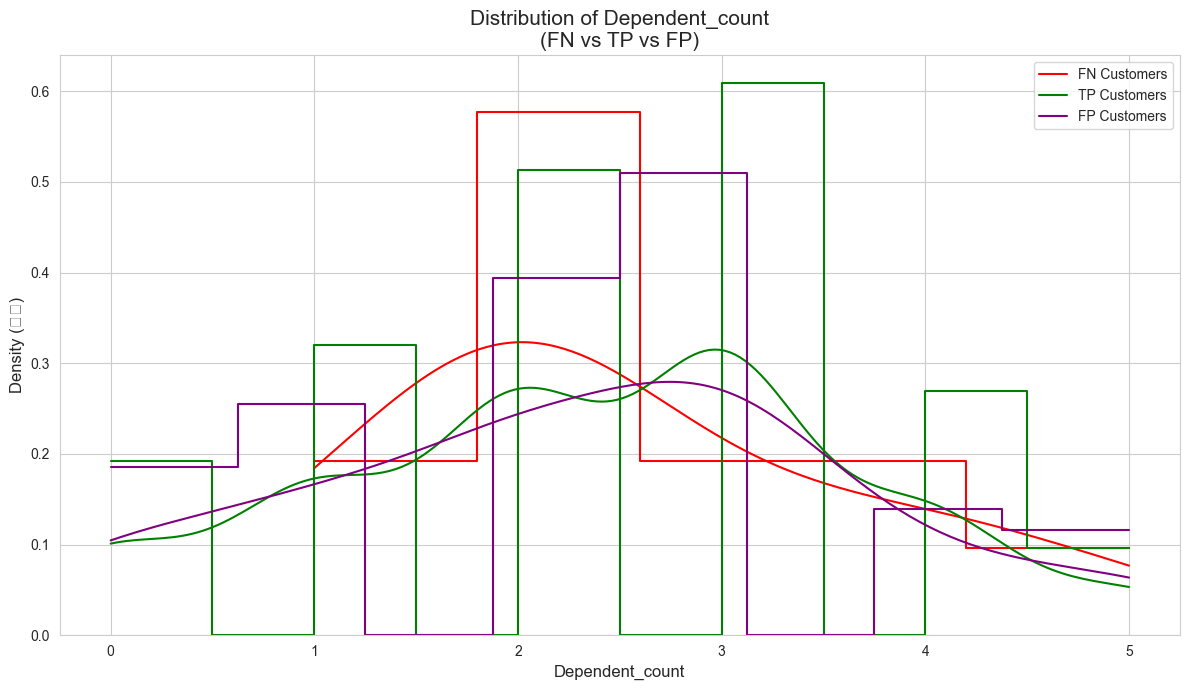

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


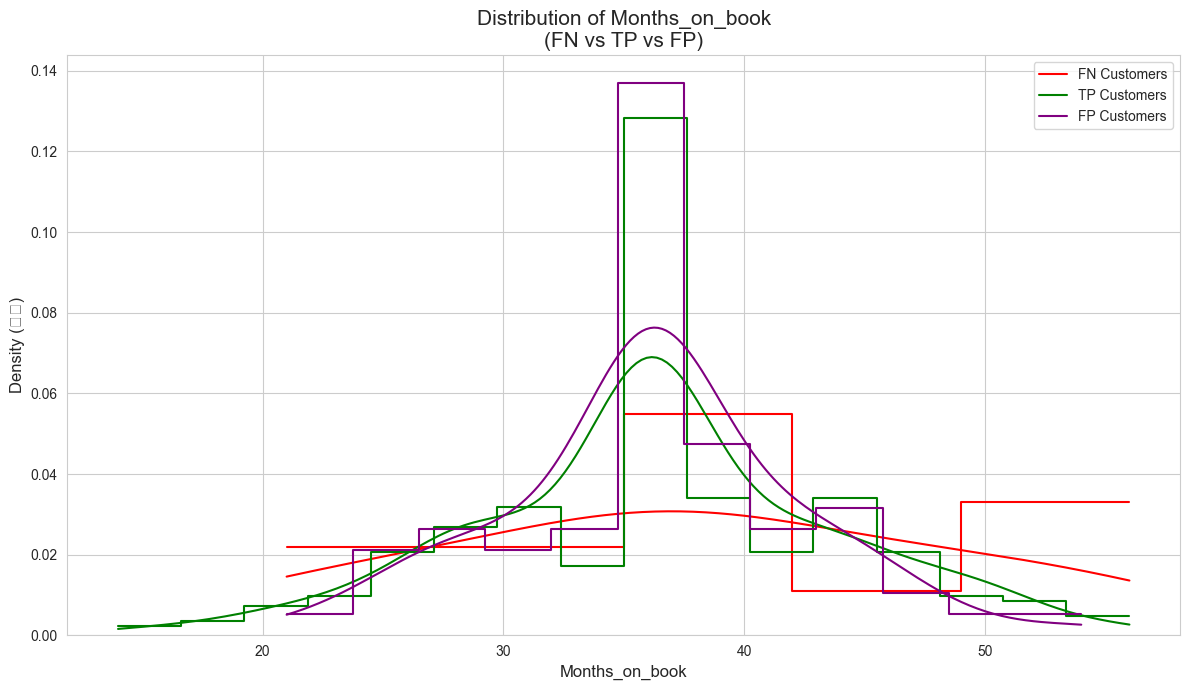

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


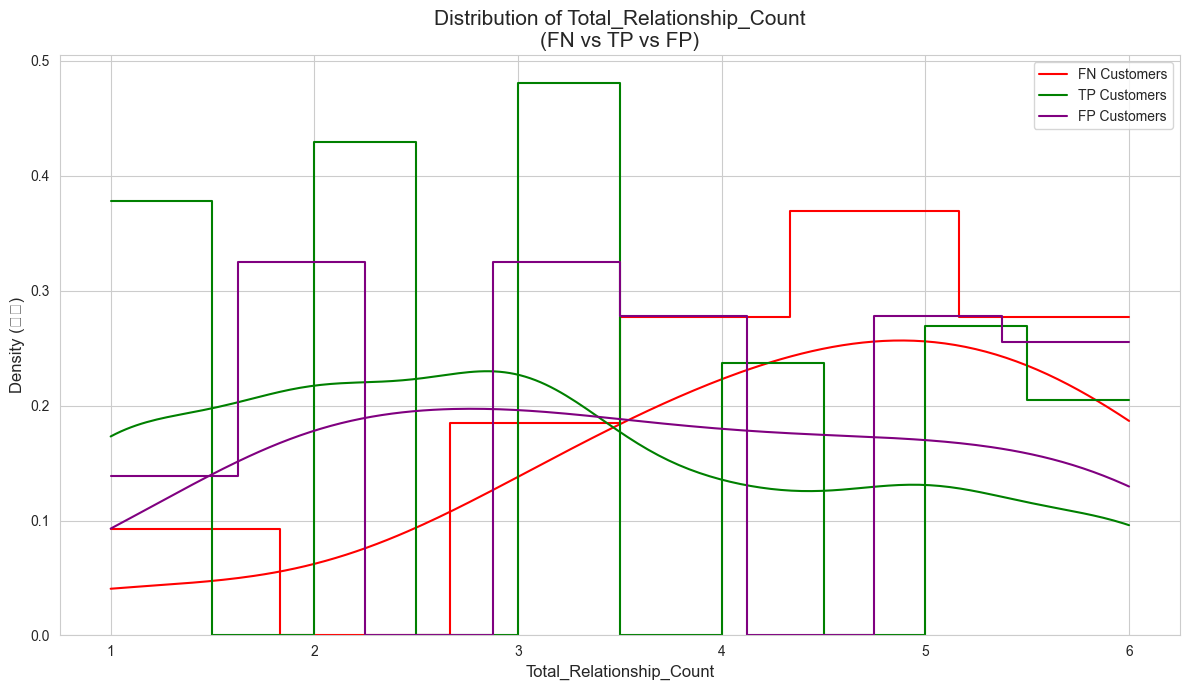

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


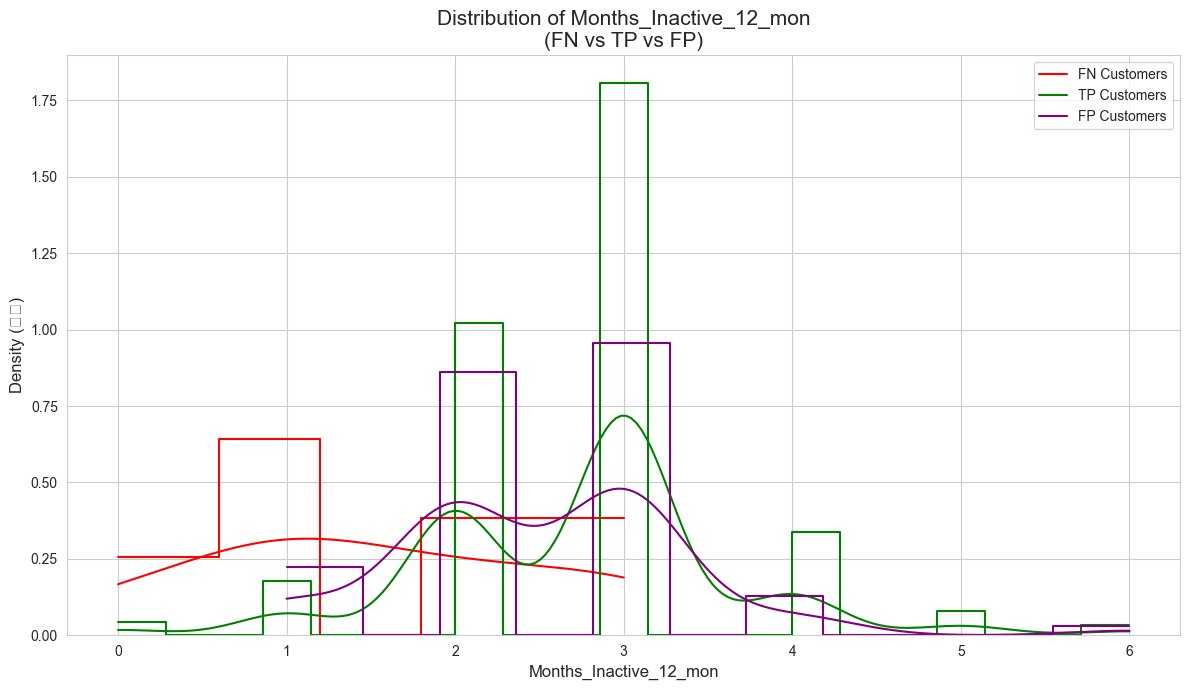

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


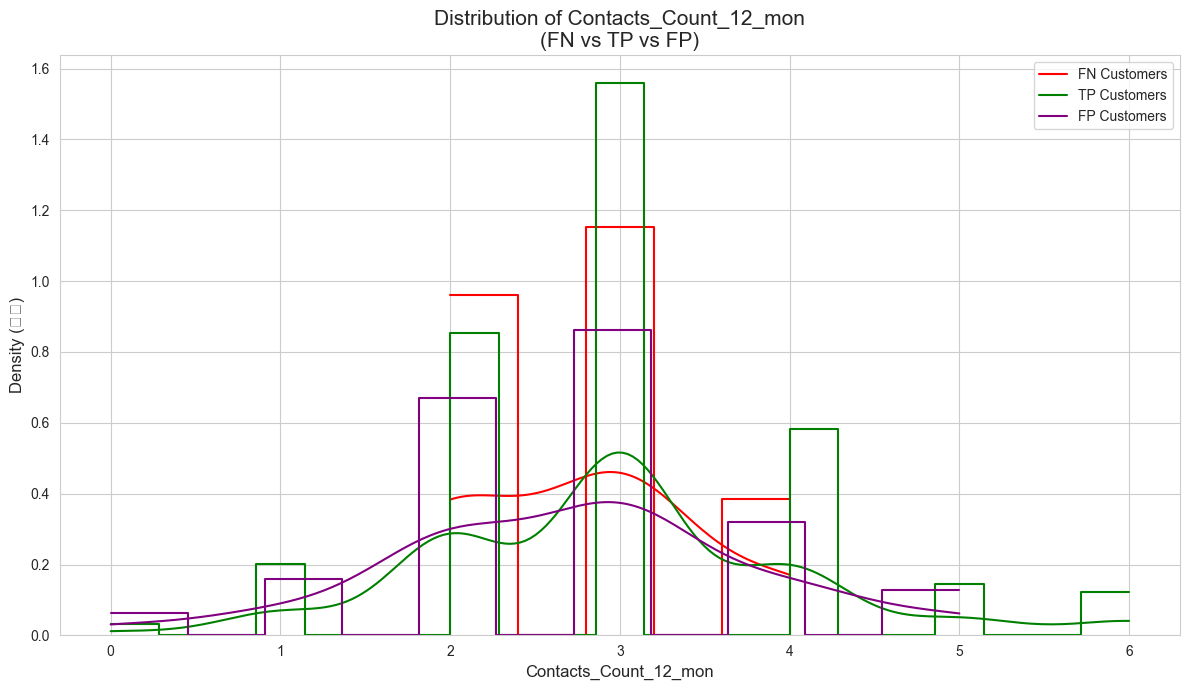

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


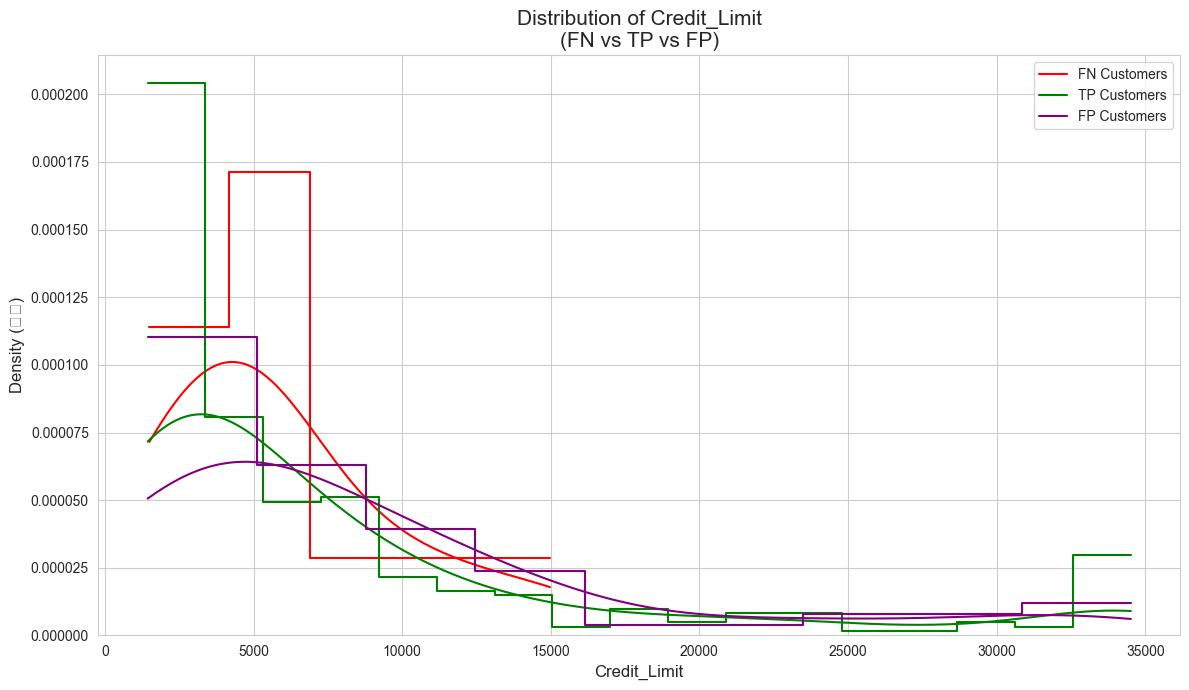

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


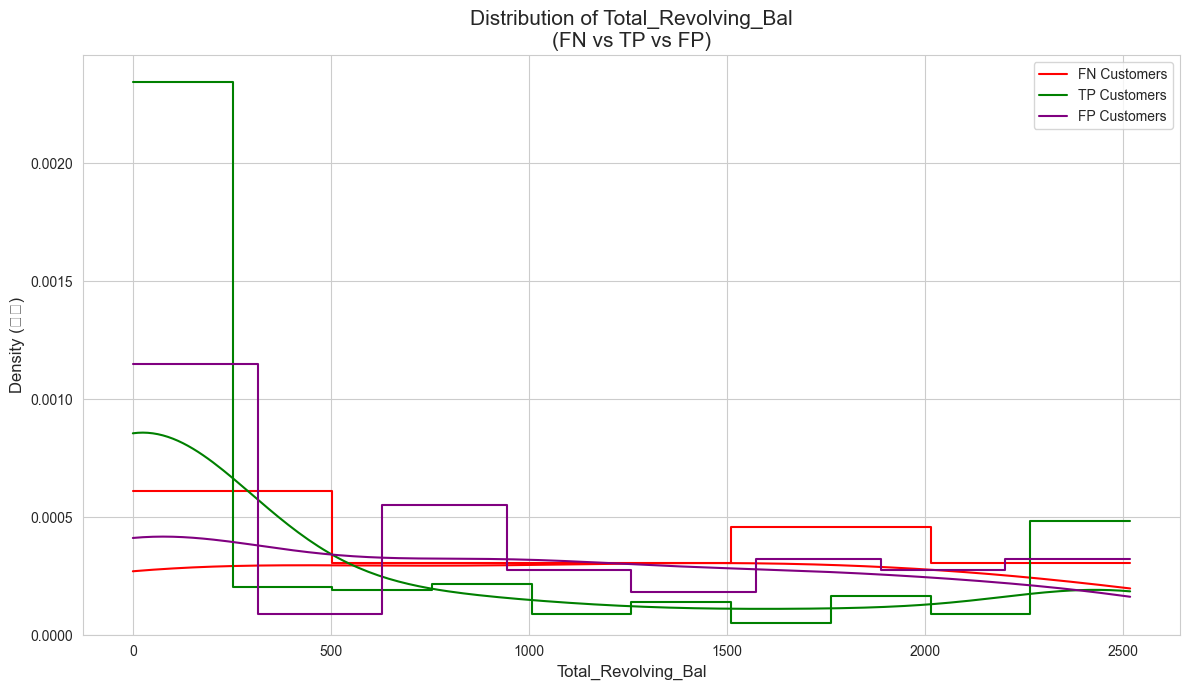

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


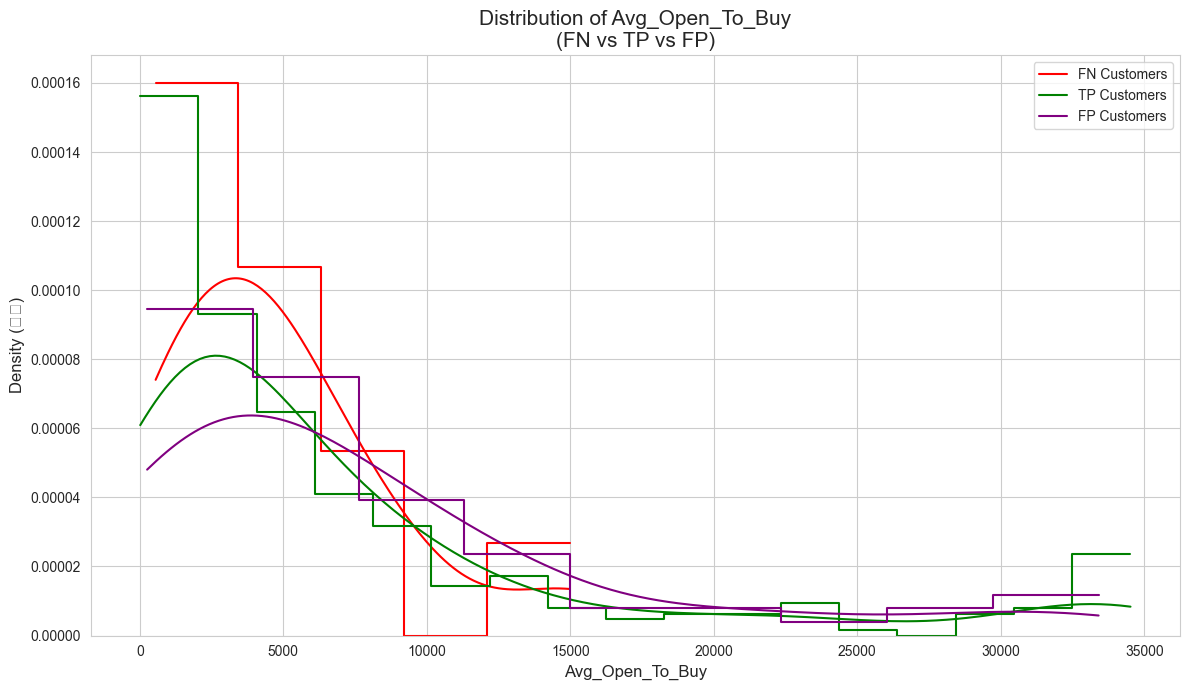

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


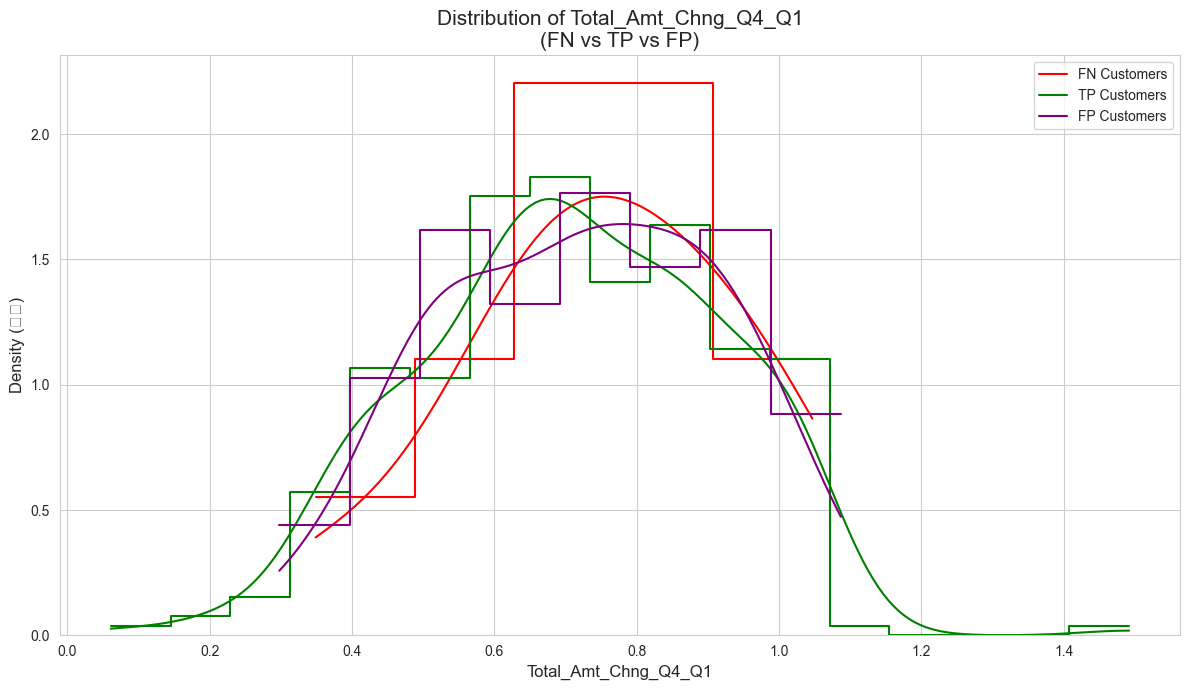

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


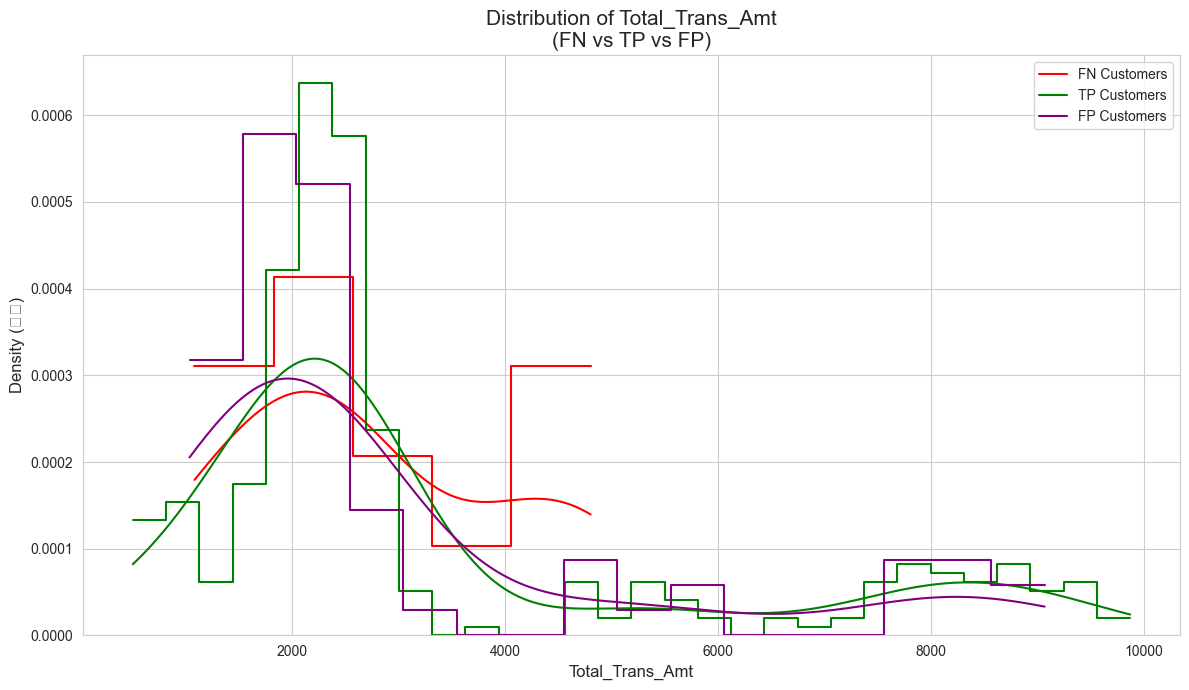

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


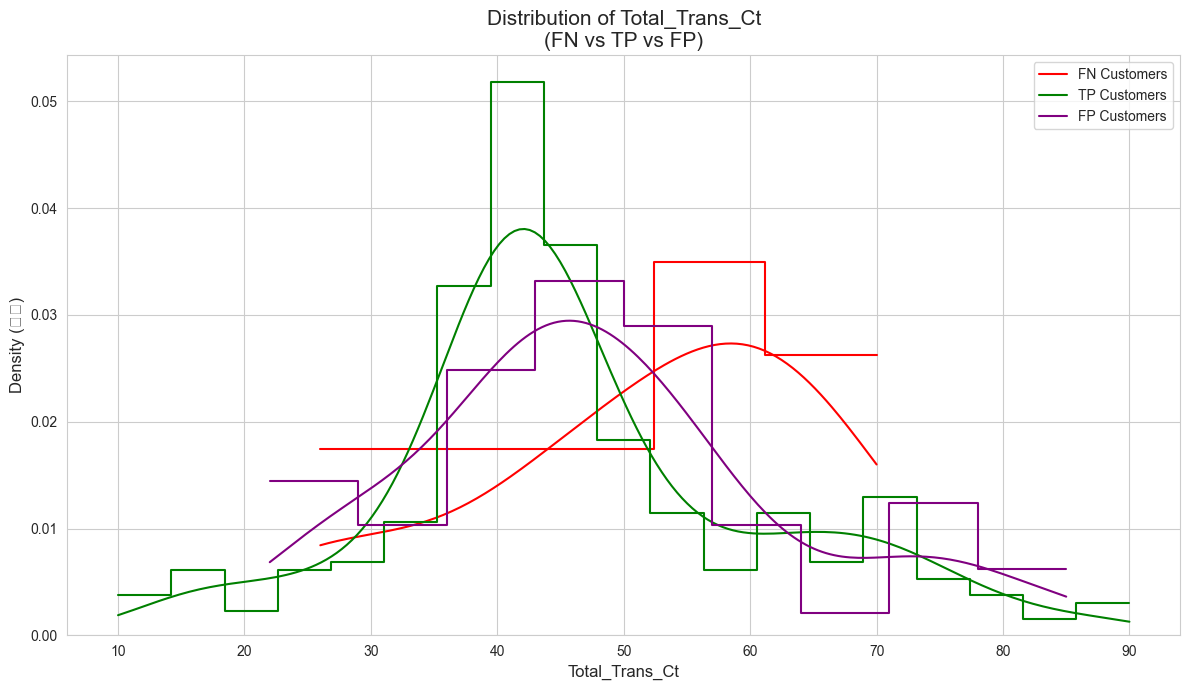

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


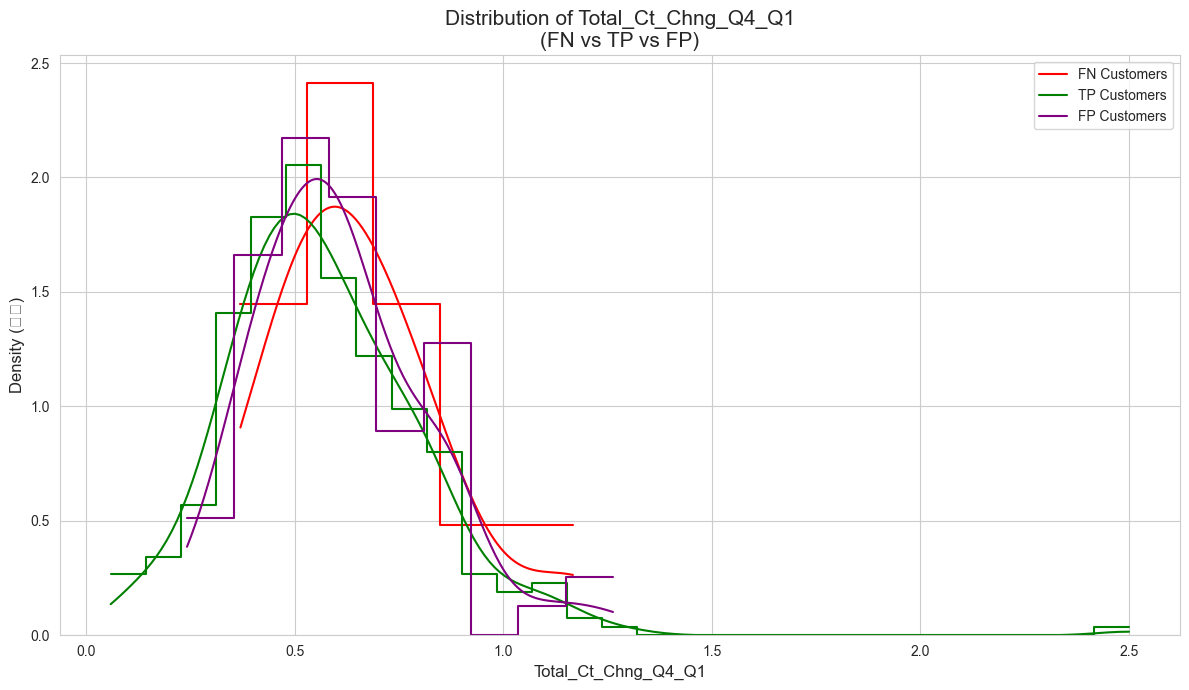

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


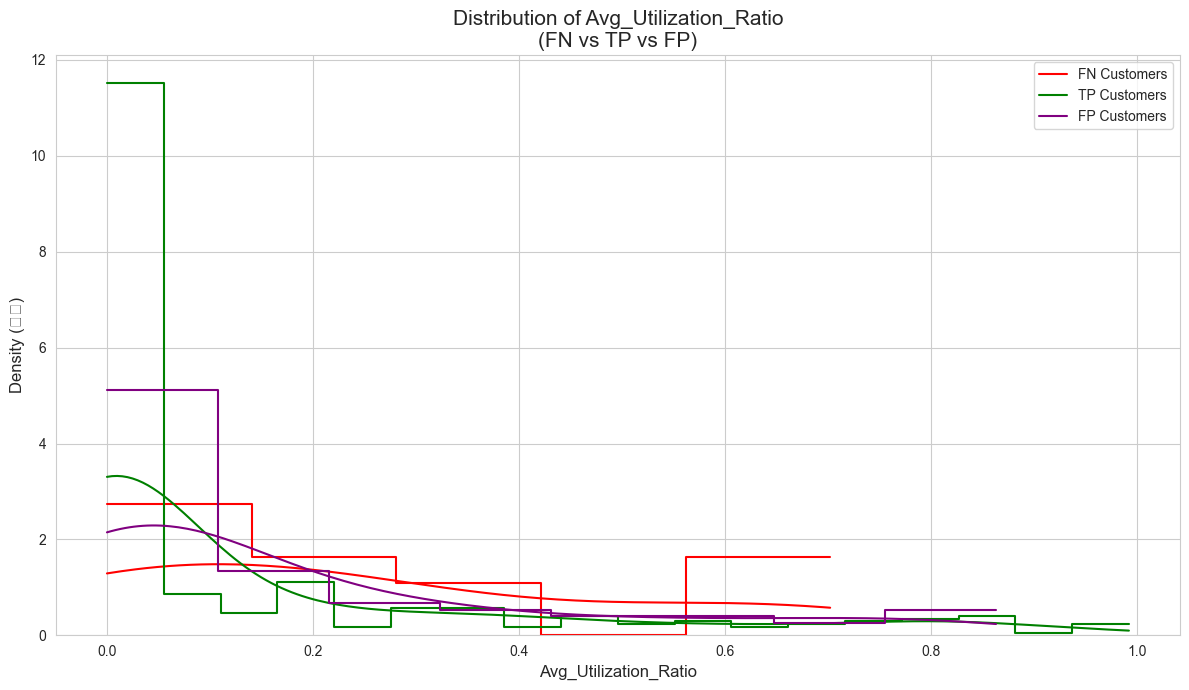



--- 類別型特徵比例比較 (FN vs TP vs FP) ---


C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


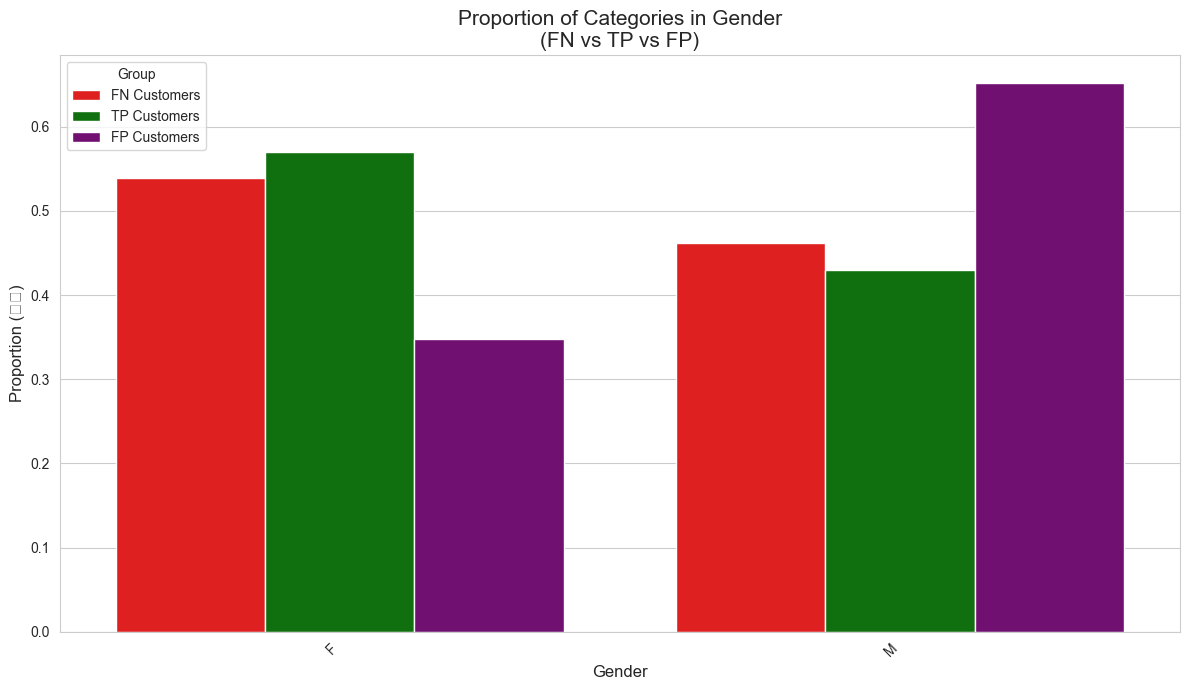

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


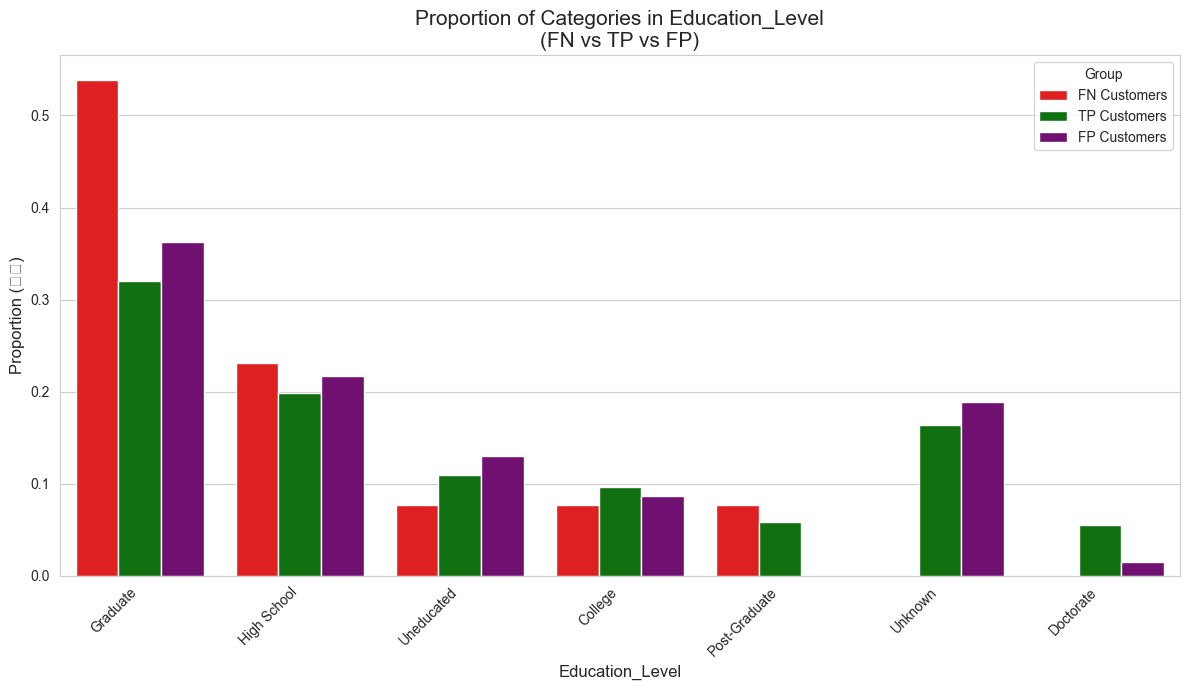

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


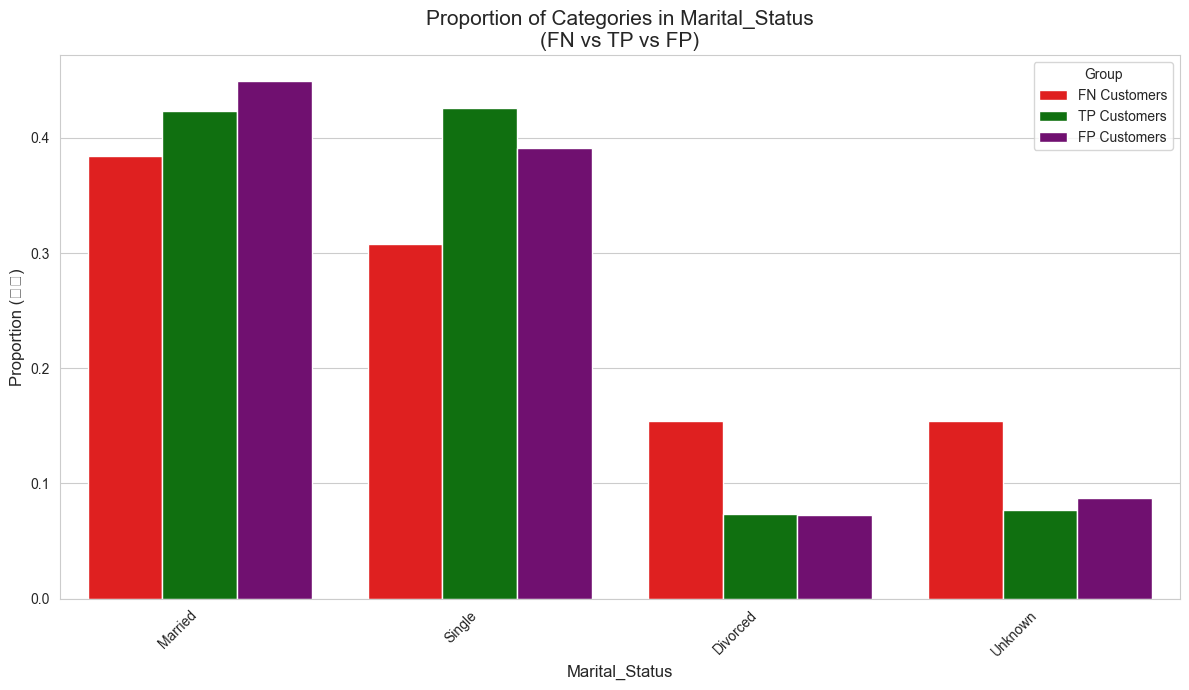

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


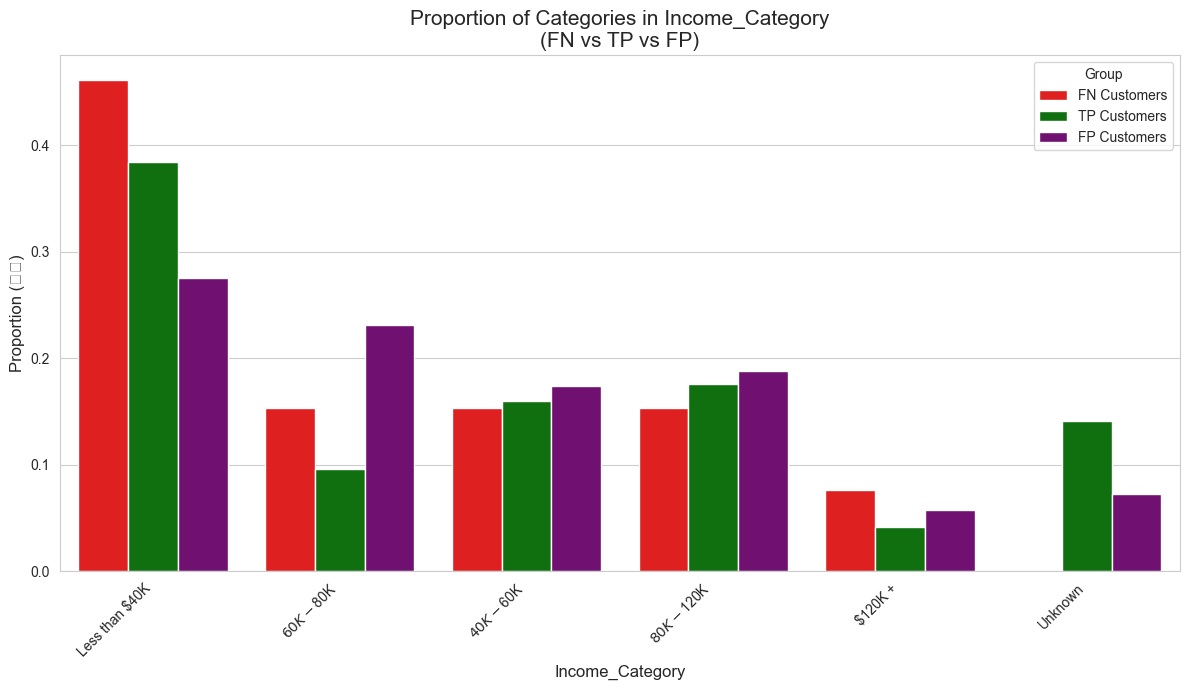

C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_20024\44002295.py:135: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


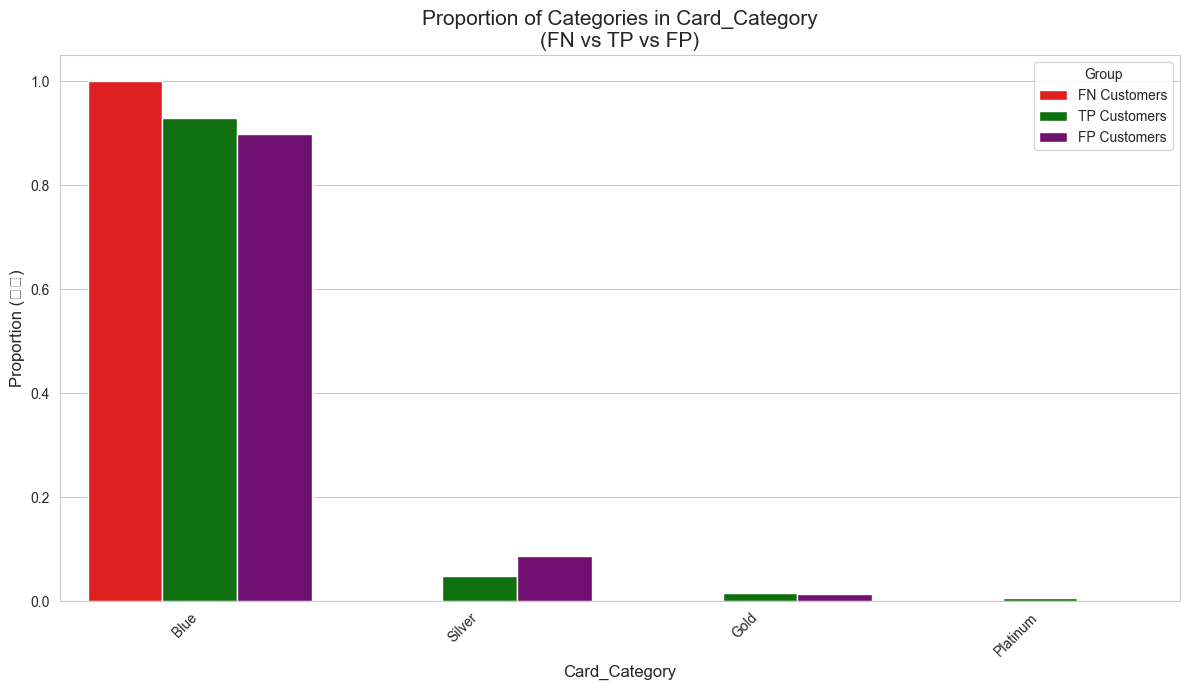



FN, TP, 與 FP 特徵比較繪圖完成。


In [21]:
# --- 請將此程式碼區塊複製到 Jupyter Notebook 的新 cell 並執行 ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 設定繪圖風格
sns.set_style("whitegrid")

# 假設 y_test, y_pred, 和 test_df 已經在之前的 cell 中定義並可用
# y_test: Series 包含測試集的真實標籤
# y_pred: array 包含模型對測試集的預測標籤
# test_df: DataFrame 包含完整測試集的原始特徵

if 'y_test' not in locals() or 'y_pred' not in locals() or 'test_df' not in locals():
    print("錯誤：'y_test', 'y_pred', 或 'test_df' 未定義。請確保這些變數可用。")
else:
    # 1. 識別 False Negatives (FN)
    # FN: y_test == 1 (實際流失) AND y_pred == 0 (預測未流失)
    fn_mask = (y_test == 1) & (y_pred == 0)
    fn_customers_original = test_df[fn_mask]
    print(f"找到 {fn_customers_original.shape[0]} 位 False Negative (FN) 客戶。")

    # 2. 識別 True Positives (TP)
    # TP: y_test == 1 (實際流失) AND y_pred == 1 (預測流失)
    tp_mask = (y_test == 1) & (y_pred == 1)
    tp_customers_original = test_df[tp_mask]
    print(f"找到 {tp_customers_original.shape[0]} 位 True Positive (TP) 客戶。")

    # 3. 識別 False Positives (FP)
    # FP: y_test == 0 (實際未流失) AND y_pred == 1 (預測流失)
    fp_mask = (y_test == 0) & (y_pred == 1)
    fp_customers_original = test_df[fp_mask]
    print(f"找到 {fp_customers_original.shape[0]} 位 False Positive (FP) 客戶。\n")

    if fn_customers_original.empty and tp_customers_original.empty and fp_customers_original.empty:
        print("注意：未能找到任何 FN, TP, 或 FP 客戶。無法進行比較。請檢查模型預測或資料。")
    else:
        print("將比較 FN, TP, 與 FP 客戶的特徵分佈。\n")

        # 獲取用於繪圖的欄位列表，排除 CLIENTNUM 和 Attrition_Flag
        # 我們可以從 test_df 中獲取欄位列表，因為所有子集都源於它
        columns_to_plot = [col for col in test_df.columns if col not in ['CLIENTNUM', 'Attrition_Flag']]

        # 分離數值型和類別型欄位
        numerical_cols = test_df[columns_to_plot].select_dtypes(include=['number']).columns.tolist()
        categorical_cols = test_df[columns_to_plot].select_dtypes(include=['object', 'category']).columns.tolist()

        # 定義顏色
        colors = {'FN Customers': 'red', 'TP Customers': 'green', 'FP Customers': 'purple'}

        print("--- 數值型特徵分佈比較 (FN vs TP vs FP) ---")
        if not numerical_cols:
            print("資料中未找到數值型特徵可供繪圖。")
        else:
            for col in numerical_cols:
                plt.figure(figsize=(12, 7))

                if not fn_customers_original.empty:
                    sns.histplot(fn_customers_original[col], color=colors['FN Customers'], label='FN Customers', kde=True, stat="density", common_norm=False, element="step", fill=False)
                if not tp_customers_original.empty:
                    sns.histplot(tp_customers_original[col], color=colors['TP Customers'], label='TP Customers', kde=True, stat="density", common_norm=False, element="step", fill=False)
                if not fp_customers_original.empty:
                    sns.histplot(fp_customers_original[col], color=colors['FP Customers'], label='FP Customers', kde=True, stat="density", common_norm=False, element="step", fill=False)

                plt.title(f'Distribution of {col}\n(FN vs TP vs FP)', fontsize=15)
                plt.xlabel(col, fontsize=12)
                plt.ylabel('Density (密度)', fontsize=12)
                if not (fn_customers_original.empty and tp_customers_original.empty and fp_customers_original.empty):
                    plt.legend()
                plt.tight_layout()
                plt.show()
            print("\n")

        print("--- 類別型特徵比例比較 (FN vs TP vs FP) ---")
        if not categorical_cols:
            print("資料中未找到類別型特徵可供繪圖。")
        else:
            all_props = []
            if not fn_customers_original.empty:
                for col in categorical_cols:
                    prop = fn_customers_original[col].value_counts(normalize=True).reset_index()
                    prop.columns = [col, 'Proportion']
                    prop['Group'] = 'FN Customers'
                    all_props.append(prop)

            if not tp_customers_original.empty:
                for col in categorical_cols:
                    prop = tp_customers_original[col].value_counts(normalize=True).reset_index()
                    prop.columns = [col, 'Proportion']
                    prop['Group'] = 'TP Customers'
                    all_props.append(prop)

            if not fp_customers_original.empty:
                for col in categorical_cols:
                    prop = fp_customers_original[col].value_counts(normalize=True).reset_index()
                    prop.columns = [col, 'Proportion']
                    prop['Group'] = 'FP Customers'
                    all_props.append(prop)

            if all_props:
                # 為了避免合併不同欄位的比例，我們逐個欄位繪圖
                for col in categorical_cols:
                    props_for_col = []
                    if not fn_customers_original.empty:
                        fn_prop_col = fn_customers_original[col].value_counts(normalize=True).reset_index()
                        fn_prop_col.columns = [col, 'Proportion']
                        fn_prop_col['Group'] = 'FN Customers'
                        props_for_col.append(fn_prop_col)

                    if not tp_customers_original.empty:
                        tp_prop_col = tp_customers_original[col].value_counts(normalize=True).reset_index()
                        tp_prop_col.columns = [col, 'Proportion']
                        tp_prop_col['Group'] = 'TP Customers'
                        props_for_col.append(tp_prop_col)

                    if not fp_customers_original.empty:
                        fp_prop_col = fp_customers_original[col].value_counts(normalize=True).reset_index()
                        fp_prop_col.columns = [col, 'Proportion']
                        fp_prop_col['Group'] = 'FP Customers'
                        props_for_col.append(fp_prop_col)

                    if not props_for_col: # 如果該欄位在所有群組中都沒有數據
                        continue

                    combined_prop_col = pd.concat(props_for_col, axis=0)

                    plt.figure(figsize=(12, 7))
                    sns.barplot(x=col, y='Proportion', hue='Group', data=combined_prop_col, palette=colors)

                    plt.title(f'Proportion of Categories in {col}\n(FN vs TP vs FP)', fontsize=15)
                    plt.xlabel(col, fontsize=12)
                    plt.ylabel('Proportion (比例)', fontsize=12)
                    plt.xticks(rotation=45, ha='right')
                    plt.legend(title='Group')
                    plt.tight_layout()
                    plt.show()
            else: # 如果所有群組都為空
                print("所有選定群組 (FN, TP, FP) 皆無數據可供繪製類別型特徵圖。")

            print("\n")

        print("FN, TP, 與 FP 特徵比較繪圖完成。")

# --- 程式碼區塊結束 ---